In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [ ]:
!pip install -qqq cartopy pytorch-msssim

In [ ]:
import xarray as xr
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from gravity import Gravity as G
from torch import clamp
from pytorch_msssim import ssim
from torch.utils.data import DataLoader, TensorDataset, random_split
from coliolis_param import Coliolis_parameter as fparam

In [ ]:

def ssim_loss(fake, real):
    return 1 - ssim(fake, real, data_range=1, size_average=True)

In [ ]:
def preprocess_temporal_info(dates):
    years = []
    months = []
    days = []
    hours = []
    minutes = []
    seconds = []

    for date in dates:
        year, month, day = date
        years.append(year)
        months.append(month - 1)  # zero-based for one-hot encoding
        days.append(day)


    # Normalize year
    years = np.array(years)
    if years.max() == years.min():
        years = np.zeros_like(years)  # Set to zero if all years are the same
    else:
        years = (years - years.min()) / (years.max() - years.min())

    # One-hot encode months
    months = np.eye(12)[months]  # 12 months

    # Normalize day, hour, minute, second
    days = np.array(days) / 31.0
#     hours = np.array(hours) / 23.0
#     minutes = np.array(minutes) / 59.0
#     seconds = np.array(seconds) / 59.0
# , hours[:, None], minutes[:, None], seconds[:, None]
    # Combine all temporal features
    temporal_info = np.concatenate([years[:, None], months, days[:, None]], axis=1)
    return torch.tensor(temporal_info, dtype=torch.float32)


# Data reading and processing

In [ ]:
# Load and preprocess data
data = xr.open_dataset('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/ssh_remaped.nc')
ssh_data = data.adt.data
ssh_data[np.isnan(ssh_data)] = 0.0
ssh_data = (ssh_data - np.min(ssh_data)) / (np.max(ssh_data) - np.min(ssh_data))
ssh_data = ssh_data.reshape((ssh_data.shape[0], 1, 36, 86))  # Shape (N, 1, 36, 86)

# Convert data to tensor and ensure type is float32
ssh_data = torch.tensor(ssh_data, dtype=torch.float32).clone().detach()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def supprement_the_outlier(data,percent):
  percentile=torch.quantile(data,percent/100.,keepdim=True)
  mask=data<=percentile
  data=data*mask
  return data

In [ ]:
random_data=torch.tensor([1,2,3,89,7,-23],dtype=torch.float32)

In [ ]:
supprement_the_outlier(random_data,97)

tensor([  1.,   2.,   3.,   0.,   7., -23.])

In [ ]:
Time_info=list(zip(data.time.dt.year.data.tolist(),\
                   data.time.dt.month.data.tolist(),\
                   data.time.dt.day.data.tolist()))

In [ ]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])


{torch.Size([1, 36, 86])}

# The transformed_data

In [ ]:
All_data=[]

for image_data in ssh_data.numpy():
  # print(image_data.shape)
  d_trans=data_transforms(image_data.reshape((36, 86,1)))
  All_data.append(d_trans)


In [ ]:
transformed_data=torch.tensor([i.numpy().tolist() for i in All_data],dtype=torch.float32)

In [ ]:
temporal_info = preprocess_temporal_info(Time_info)
print(temporal_info[4500])

tensor([0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0968])


# Network Reconstruction

In [ ]:
# Example data

tensor1_reshaped = temporal_info.view(7247, 1, 1, 14).expand(-1, -1, 36, -1)

tensor1_reshape_together = torch.cat((tensor1_reshaped,tensor1_reshaped),dim=0)
data_tensor_with_transform = torch.cat((ssh_data,transformed_data),dim=0)

tensor1_reshape_together=tensor1_reshaped.clone()
# data_tensor = torch.cat((data_tensor_with_transform,tensor1_reshape_together),dim=-1)
data_tensor_with_transform=ssh_data.clone()
data_tensor = torch.cat((data_tensor_with_transform,tensor1_reshape_together),dim=-1)
print(data_tensor.shape)
# Create a TensorDataset
dataset = TensorDataset(data_tensor)


# Define the lengths of the datasets
train_size = int(0.982 * len(dataset))
validation_size = int(0.018 * len(dataset))

validation_size=224
train_size=len(dataset)-validation_size
# Split the dataset
train_dataset, validation_dataset= random_split(dataset, [train_size, validation_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the data loader lengths
print(f'Train DataLoader Length: {len(train_loader)} batches')
print(f'Validation DataLoader Length: {len(validation_loader)} batches')
# print(f'Test DataLoader Length: {len(test_loader)} batches')

torch.Size([7247, 1, 36, 100])
Train DataLoader Length: 220 batches
Validation DataLoader Length: 7 batches


In [ ]:
for batch in train_loader:
  print(batch[0].shape)
  break

torch.Size([32, 1, 36, 100])


In [ ]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 36, 100])

In [ ]:


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.in1 = nn.InstanceNorm2d(in_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.in2 = nn.InstanceNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.in1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.in2(out)
        out += residual
        return out

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class Mapping_Network(nn.Module):
    def __init__(self, in_channels, n_layers):
        super(Mapping_Network, self).__init__()
        self.model = nn.Sequential()
        for i in range(n_layers - 1):
            self.model.append(nn.Linear(in_channels, in_channels))
            self.model.append(nn.ReLU(inplace=True))
        self.model.append(nn.Linear(in_channels, in_channels))

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, input_dim, n_layers,temporaly_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            Mapping_Network(input_dim+temporaly_dim, n_layers),
            nn.Linear(input_dim+temporaly_dim, 128 * 9 * 21),  # Input: (N, input_dim) -> Output: (N, 128*9*21)
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 256, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), output_padding=(0, 1)),  # Output: (N, 256, 18, 42)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            ResidualBlock(256),
            nn.Conv2d(256, 128, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1)),  # Output: (N, 128, 18, 42)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            ResidualBlock(128),
            SelfAttention(128),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), output_padding=(0, 1)),  # Output: (N, 64, 36, 86)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), output_padding=(0, 1)),  # Output: (N, 32, 36, 86)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            ResidualBlock(32),
            SelfAttention(32),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  # Output: (N, 32, 36, 86)
            nn.Tanh()
        )
        self.last_layer = nn.Conv2d(32, 1, kernel_size=(1, 5), stride=(1, 1), padding=(0, 0))

    def forward(self, x,temporaly_data):
        x=torch.cat((x,temporaly_data),dim=1)
        x = self.fc(x)
        x = x.view(-1, 128, 9, 21)  # Reshape: (N, 128*9*21) -> (N, 128, 9, 21)
        x = self.deconv(x)  # Apply transpose convolutions
        x = self.last_layer(x)
        return x


# Discriminator Network

In [ ]:
def add_noise(inputs, mean=0, std=0.1):
  noise = torch.sin(torch.randn_like(inputs) * std + mean)
  noise = noise.to(device)
  return inputs + noise

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape,temporaly_dim):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),  # Input: (N, 1, 36, 86) -> Output: (N, 32, 18, 43)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            ResidualBlock(32),
            nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),  # Input: (N, 32, 18, 43) -> Output: (N, 64, 9, 22)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            ResidualBlock(64),
            SelfAttention(64),
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),  # Input: (N, 64, 9, 22) -> Output: (N, 128, 5, 12)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 2), padding=(2, 2)),  # Input: (N, 128, 5, 12) -> Output: (N, 128, 6, 7)
            ResidualBlock(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 7))  # Ensure consistent output size (N, 128, 6, 7)
        self.vector=nn.Flatten()
        self.fc = nn.Sequential(
              # Input: (N, 128, 6, 7) -> Output: (N, 128*6*7)
            nn.Linear(128 * 6 * 7+temporaly_dim, 1),  # Input: (N, 128*6*7) -> Output: (N, 1)
            nn.Sigmoid()
        )

    def forward(self, x,temporaly_data):
        # noise=torch.randn(x.size())*0.1
        # noise=noise.to(device)
        # print(device)
        # print('all devices: ',x.device,noise.device)
        # noisy_input=x+noise
        x=add_noise(x)
        x = self.conv(x)
        x = self.adaptive_pool(x)
        x_vector=self.vector(x)
        x=torch.cat((x_vector,temporaly_data),dim=1)
        x = self.fc(x)
        return x


In [ ]:
# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         torch.nn.init.orthogonal_(m.weight,0.02)
#         if m.bias is not None:
#             torch.nn.init.constant_(m.bias, 0)

# def gradient_penalty(real_data, fake_data, discriminator,time_data, lambda_gp=5):
#     batch_size = real_data.size(0)
#     alpha = torch.rand(batch_size, 1, 1, 1).to(device)  # Random weight between real and fake data
#     interpolates = alpha * real_data + (1 - alpha) * fake_data
#     interpolates = interpolates.clone().detach().requires_grad_(True)  # Now it's a leaf node
#     outputs = discriminator(interpolates,time_data)
#     gradients = torch.autograd.grad(
#         outputs, interpolates, grad_outputs=torch.ones_like(outputs), create_graph=True
#     )[0]
#     gradients = gradients.view(batch_size, -1)  # Flatten
#     return lambda_gp * ((gradients.norm(2, dim=1) - 1)**2).mean()

# input_dim = 200
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# temporaly_dim=temporal_info.shape[1]

# generator = Generator(input_dim, n_layers=4,temporaly_dim=temporaly_dim).to(device)
# discriminator = Discriminator((1, 36, 86),temporaly_dim=temporaly_dim).to(device)

# input_dim = 200
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# temporaly_dim=temporal_info.shape[1]

# generator = Generator(input_dim, n_layers=4,temporaly_dim=temporaly_dim).to(device)
# discriminator = Discriminator((1, 36, 86),temporaly_dim=temporaly_dim).to(device)

# generator.apply(weights_init)
# discriminator.apply(weights_init)

# # Loss and optimizers
# optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# The column for reloading the weights

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight,gain=torch.nn.init.calculate_gain('relu'))
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

def gradient_penalty(real_data, fake_data, discriminator,time_data, lambda_gp=10):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)  # Random weight between real and fake data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.clone().detach().requires_grad_(True)  # Now it's a leaf node
    outputs = discriminator(interpolates,time_data)
    gradients = torch.autograd.grad(
        outputs, interpolates, grad_outputs=torch.ones_like(outputs), create_graph=True
    )[0]
    gradients = gradients.view(batch_size, -1)  # Flatten
    return lambda_gp * ((gradients.norm(2, dim=1) - 1)**2).mean()

input_dim = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
temporaly_dim=temporal_info.shape[1]

generator = Generator(input_dim, n_layers=4,temporaly_dim=temporaly_dim).to(device)
discriminator = Discriminator((1, 36, 86),temporaly_dim=temporaly_dim).to(device)

input_dim = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
temporaly_dim=temporal_info.shape[1]

generator = Generator(input_dim, n_layers=4,temporaly_dim=temporaly_dim)
discriminator = Discriminator((1, 36, 86),temporaly_dim=temporaly_dim)

if torch.cuda.is_available():
  generator = nn.DataParallel(generator).cuda()
  discriminator = nn.DataParallel(discriminator).cuda()

generator.apply(weights_init)
discriminator.apply(weights_init)

generator.load_state_dict(torch.load('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/gen_weights_epoch_333_96.pth'))
discriminator.load_state_dict(torch.load('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/disc_weights_epoch_333_96.pth'))
# generator.apply(weights_init)
# discriminator.apply(weights_init)

# Loss and optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))



In [ ]:
starting_epoch=36

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/pytorch_msssim/ssim.py:48: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Trigg

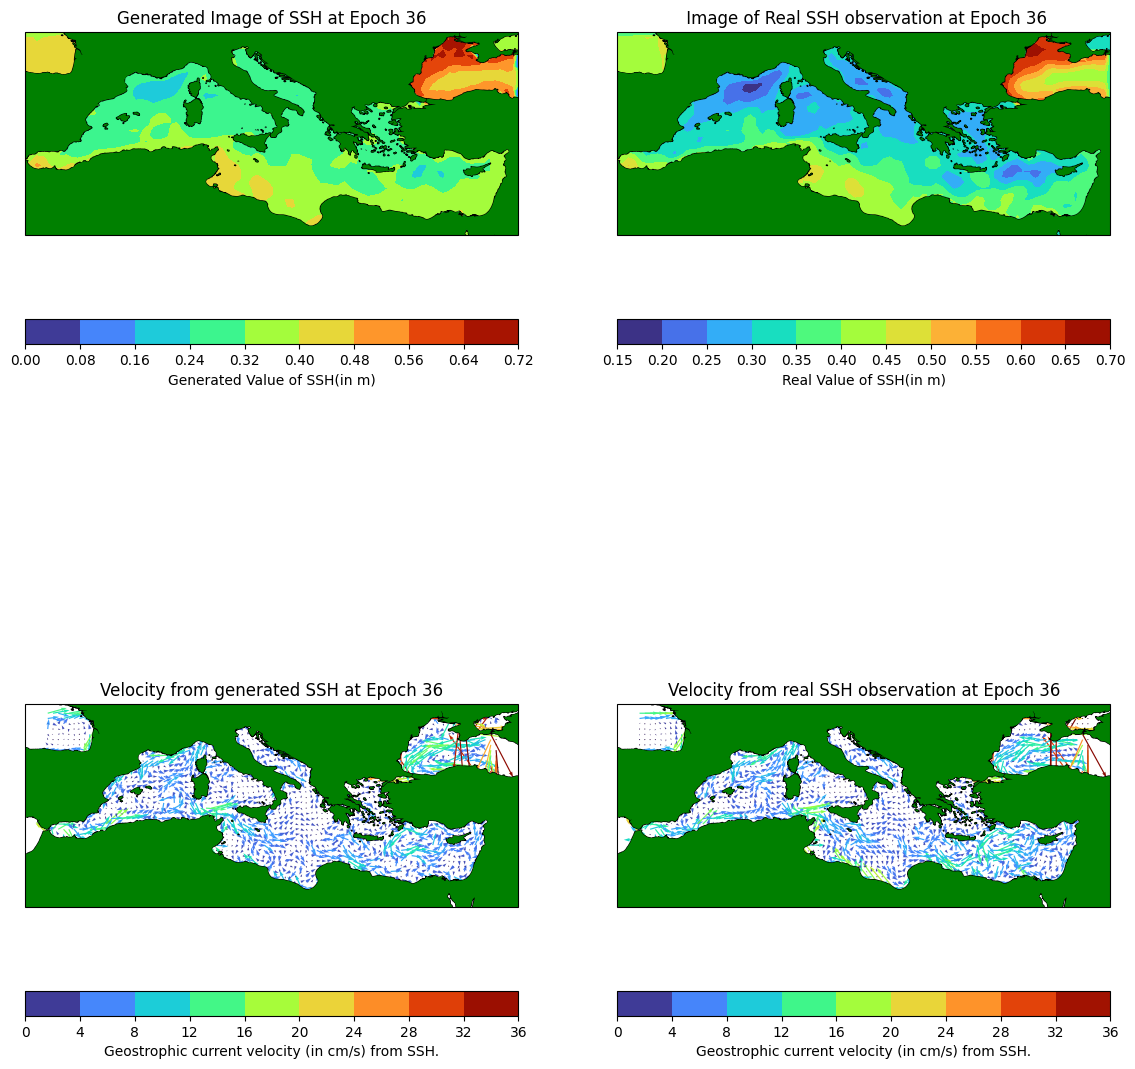

Epoch [36/100]  Loss_D: -0.013667318969964981, Loss_G: -0.3949613571166992
Epoch [36/100]  Mean Loss_D: 0.02613874264908108, Mean Loss_G: -0.3056452598084103
Epoch [37/100]  Mean Loss_D: 0.02174730766987936, Mean Loss_G: -0.30590763105587526
Epoch [38/100]  Mean Loss_D: 0.03452839263517297, Mean Loss_G: -0.30989025993780656
Epoch [39/100]  Mean Loss_D: 0.027415963567116043, Mean Loss_G: -0.3093226486309008
Epoch [40/100]  Mean Loss_D: 0.023533148333768954, Mean Loss_G: -0.3077561659162695


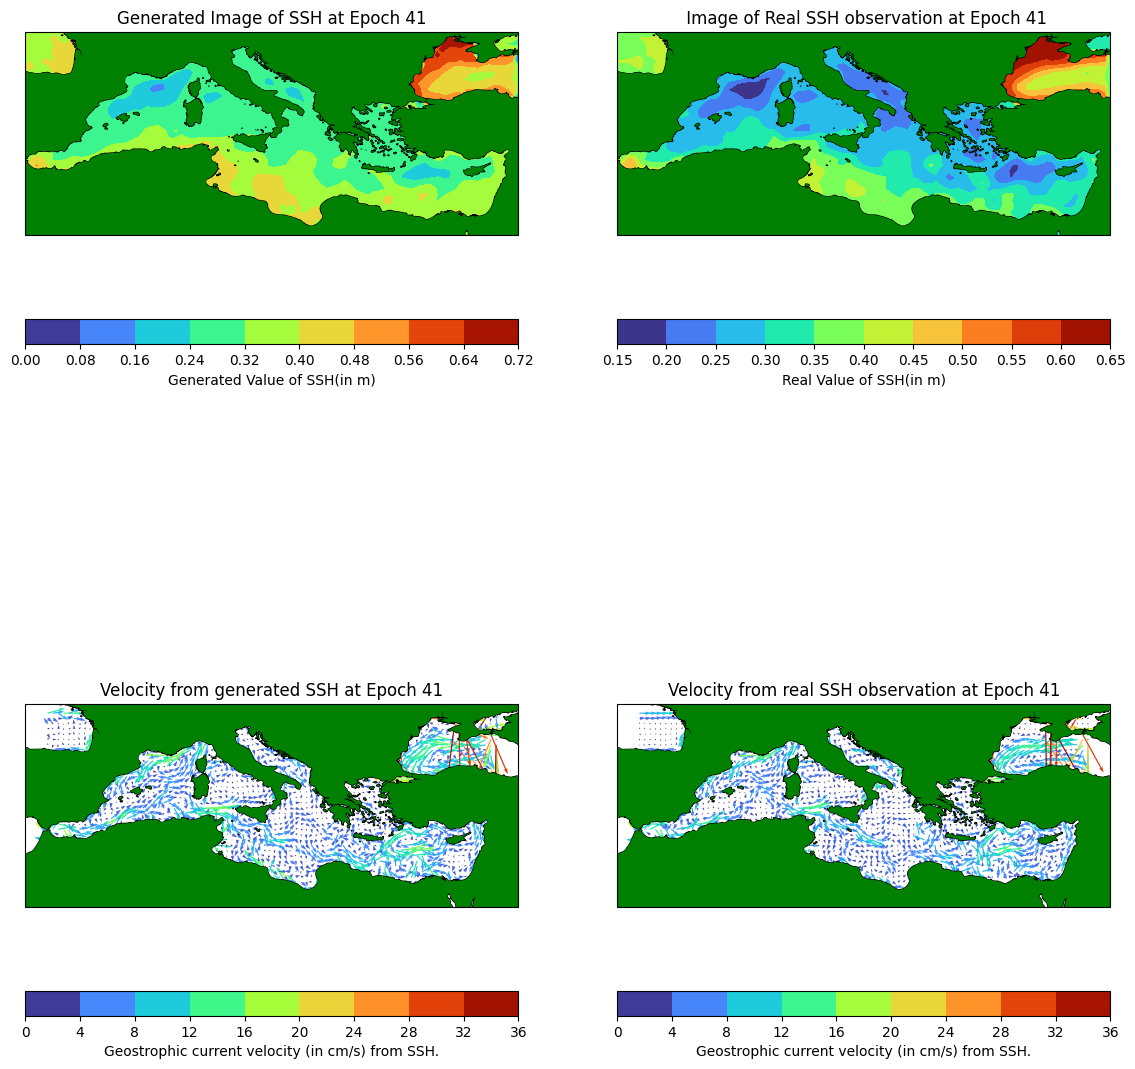

Epoch [41/100]  Loss_D: -0.026307011023163795, Loss_G: -0.29688867926597595
Epoch [41/100]  Mean Loss_D: 0.020756655701464323, Mean Loss_G: -0.3067205403564554
Epoch [42/100]  Mean Loss_D: 0.01821780845571261, Mean Loss_G: -0.306480715375442
Epoch [43/100]  Mean Loss_D: 0.7774893818137405, Mean Loss_G: -0.3487822825935754
Epoch [44/100]  Mean Loss_D: 1.8022127828711287, Mean Loss_G: -0.405538319879108
Epoch [45/100]  Mean Loss_D: 2.6219915028500624, Mean Loss_G: -0.4512517983263189


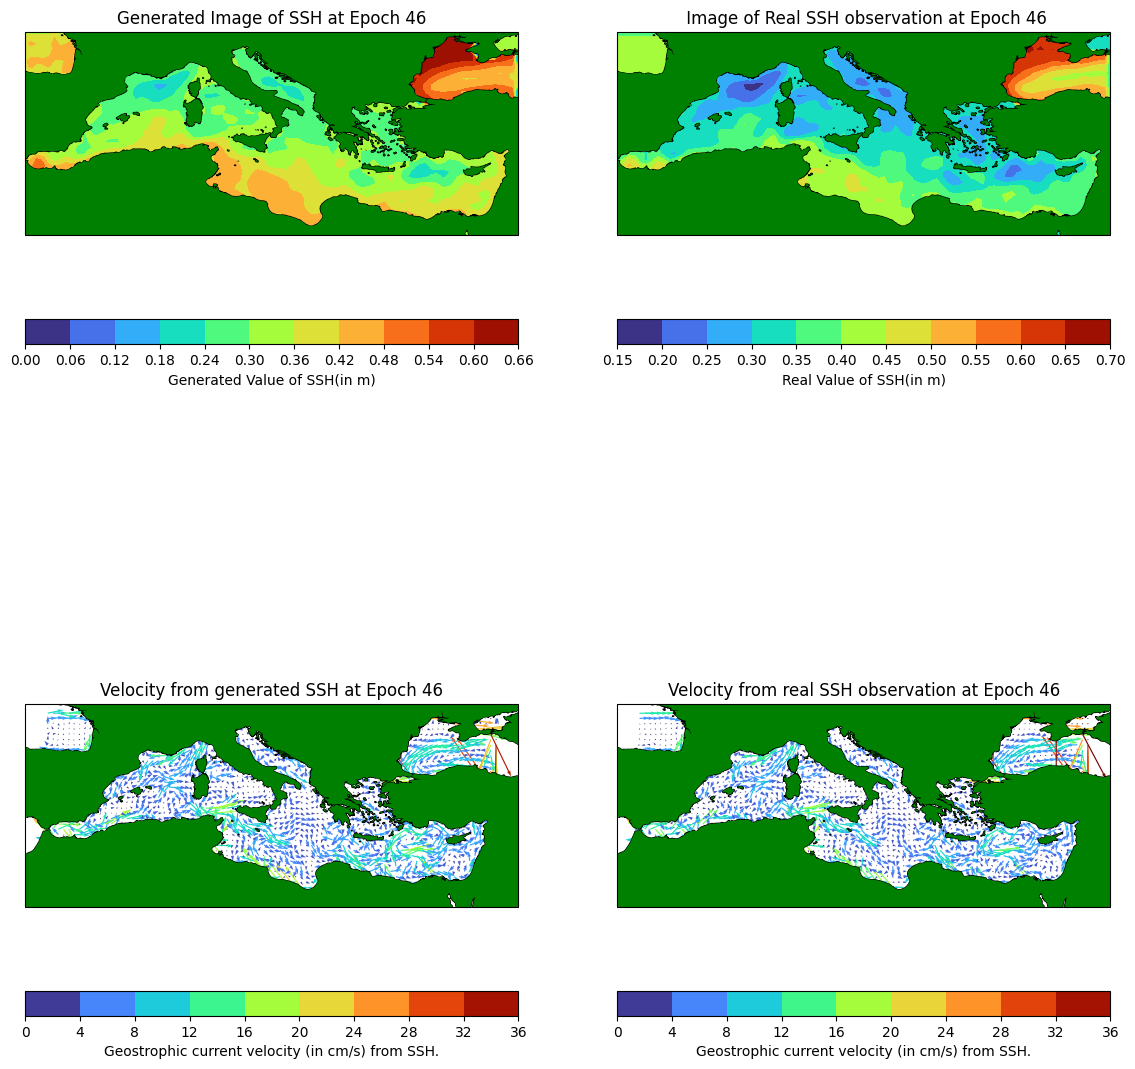

Epoch [46/100]  Loss_D: 10.0, Loss_G: -0.8692423701286316
Epoch [46/100]  Mean Loss_D: 3.292719547257351, Mean Loss_G: -0.4887402482269224
Epoch [47/100]  Mean Loss_D: 3.8516595842634245, Mean Loss_G: -0.5200372783523617
Epoch [48/100]  Mean Loss_D: 4.324608844344771, Mean Loss_G: -0.5465468416055599
Epoch [49/100]  Mean Loss_D: 4.7299939256530354, Mean Loss_G: -0.5693393805777872
Epoch [50/100]  Mean Loss_D: 5.0813276627868635, Mean Loss_G: -0.5891248502514579


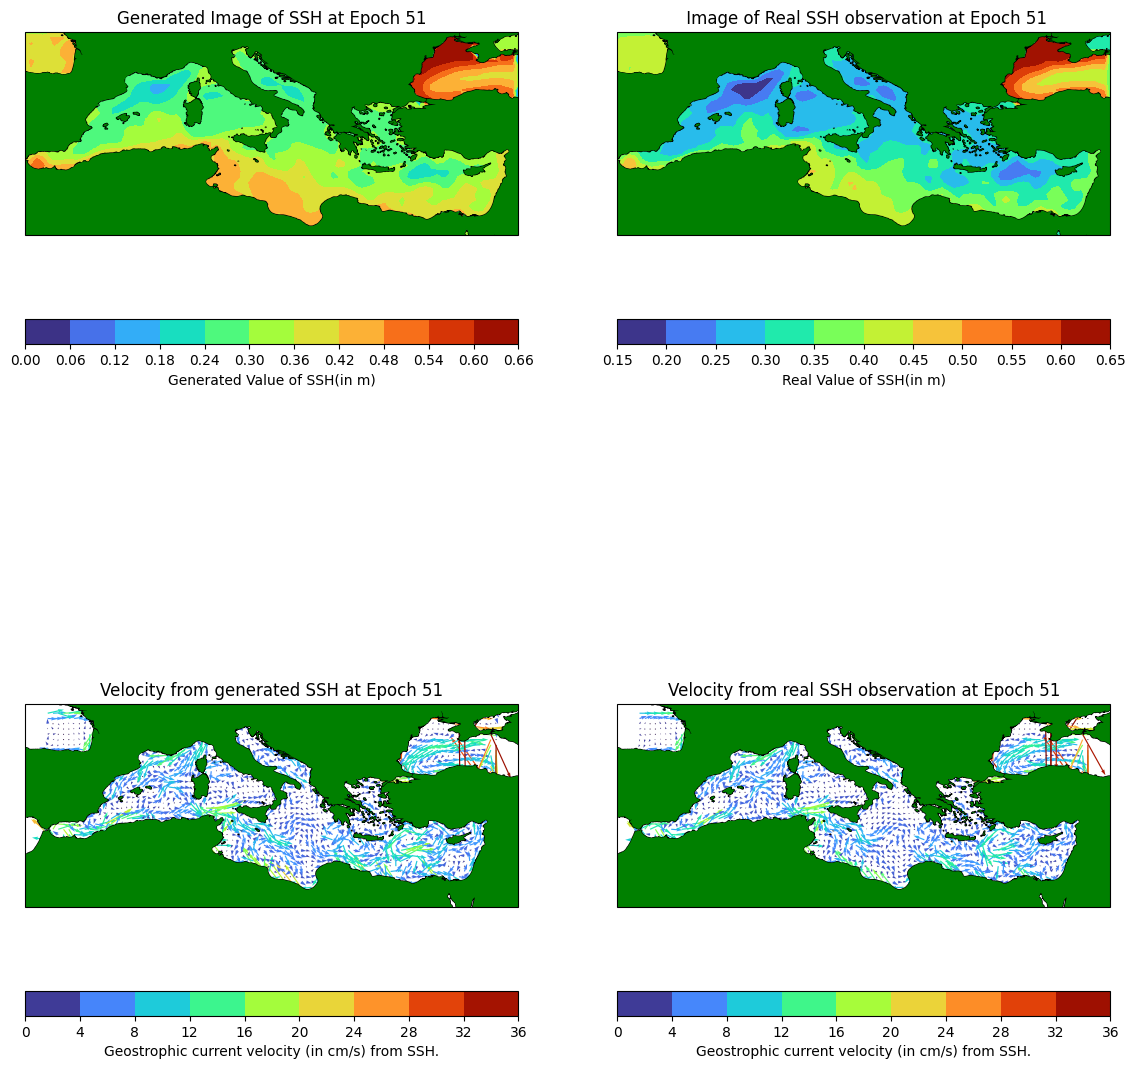

Epoch [51/100]  Loss_D: 10.0, Loss_G: 0.1343570351600647
Epoch [51/100]  Mean Loss_D: 5.391886651137611, Mean Loss_G: -0.5527328649366444
Epoch [52/100]  Mean Loss_D: 5.662952142247163, Mean Loss_G: -0.5123398587984197
Epoch [53/100]  Mean Loss_D: 5.903899245455654, Mean Loss_G: -0.4765067198210292
Epoch [54/100]  Mean Loss_D: 6.11948349569483, Mean Loss_G: -0.4444300108121343
Epoch [55/100]  Mean Loss_D: 6.3135093209100885, Mean Loss_G: -0.4155971361290325


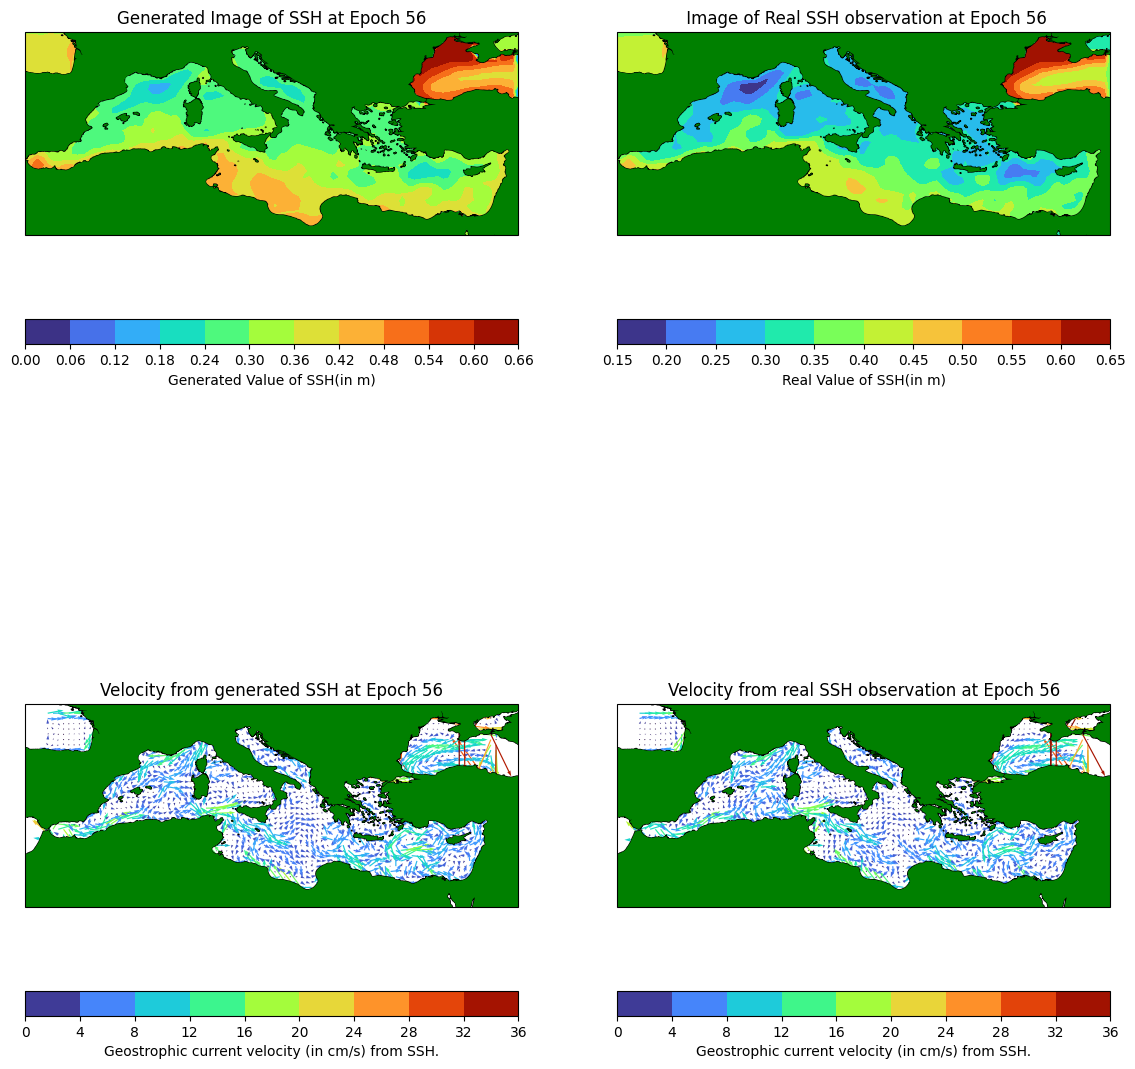

Epoch [56/100]  Loss_D: 10.0, Loss_G: 0.14895093441009521
Epoch [56/100]  Mean Loss_D: 6.489056496104847, Mean Loss_G: -0.38950471478107174
Epoch [57/100]  Mean Loss_D: 6.648644837190989, Mean Loss_G: -0.36579404138336497
Epoch [58/100]  Mean Loss_D: 6.794355931226164, Mean Loss_G: -0.34418418733734385
Epoch [59/100]  Mean Loss_D: 6.92792443409174, Mean Loss_G: -0.32437544458291745
Epoch [60/100]  Mean Loss_D: 7.050807456728071, Mean Loss_G: -0.30616082873127676


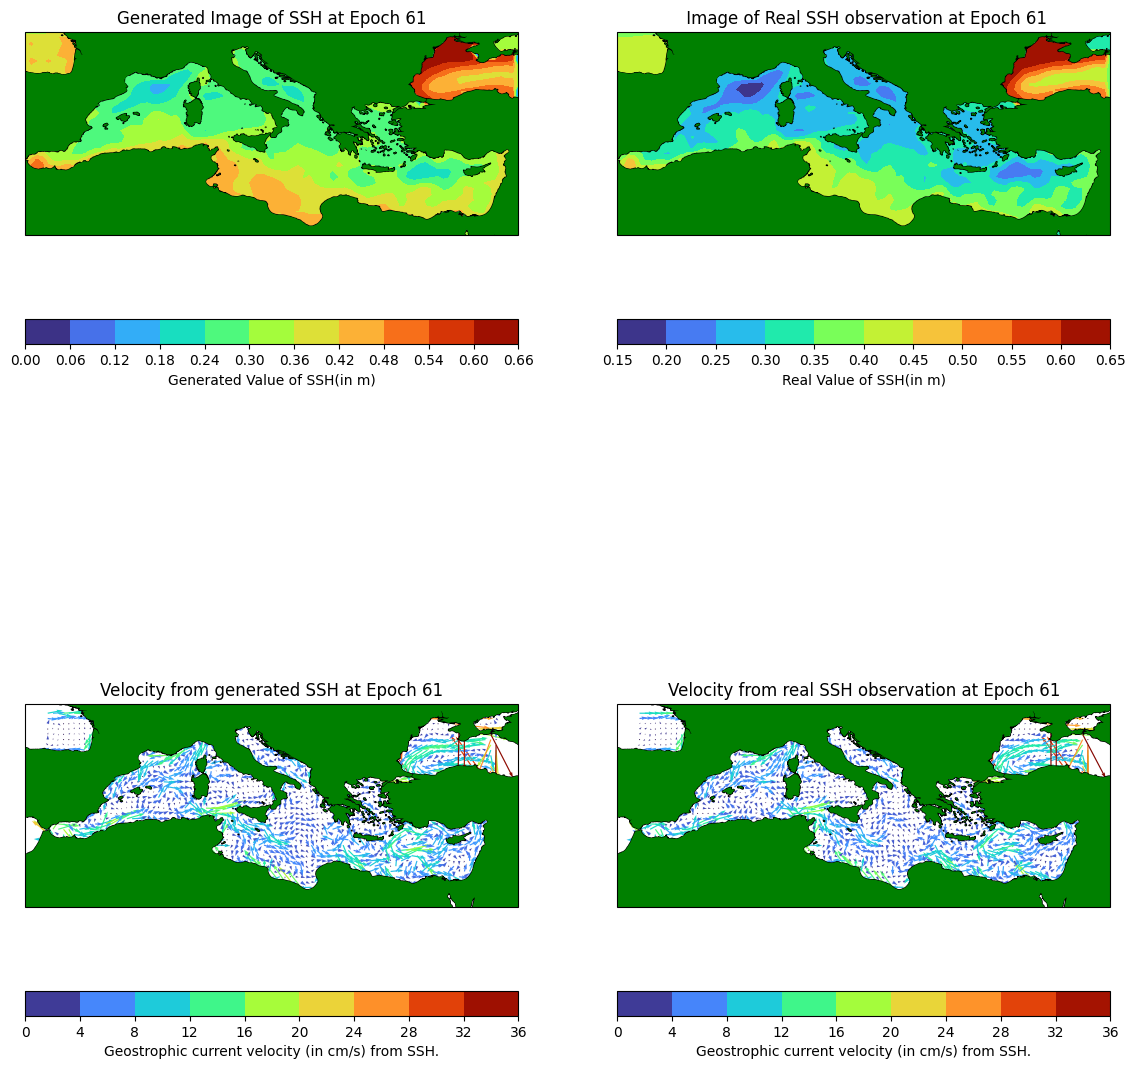

Epoch [61/100]  Loss_D: 10.0, Loss_G: 0.12864810228347778
Epoch [61/100]  Mean Loss_D: 7.164237939161607, Mean Loss_G: -0.289356114084904
Epoch [62/100]  Mean Loss_D: 7.269266163637103, Mean Loss_G: -0.27380775143000413
Epoch [63/100]  Mean Loss_D: 7.366792372078635, Mean Loss_G: -0.2593851041871232
Epoch [64/100]  Mean Loss_D: 7.457592635110406, Mean Loss_G: -0.24595759497914568
Epoch [65/100]  Mean Loss_D: 7.542339547273392, Mean Loss_G: -0.23343819503531313


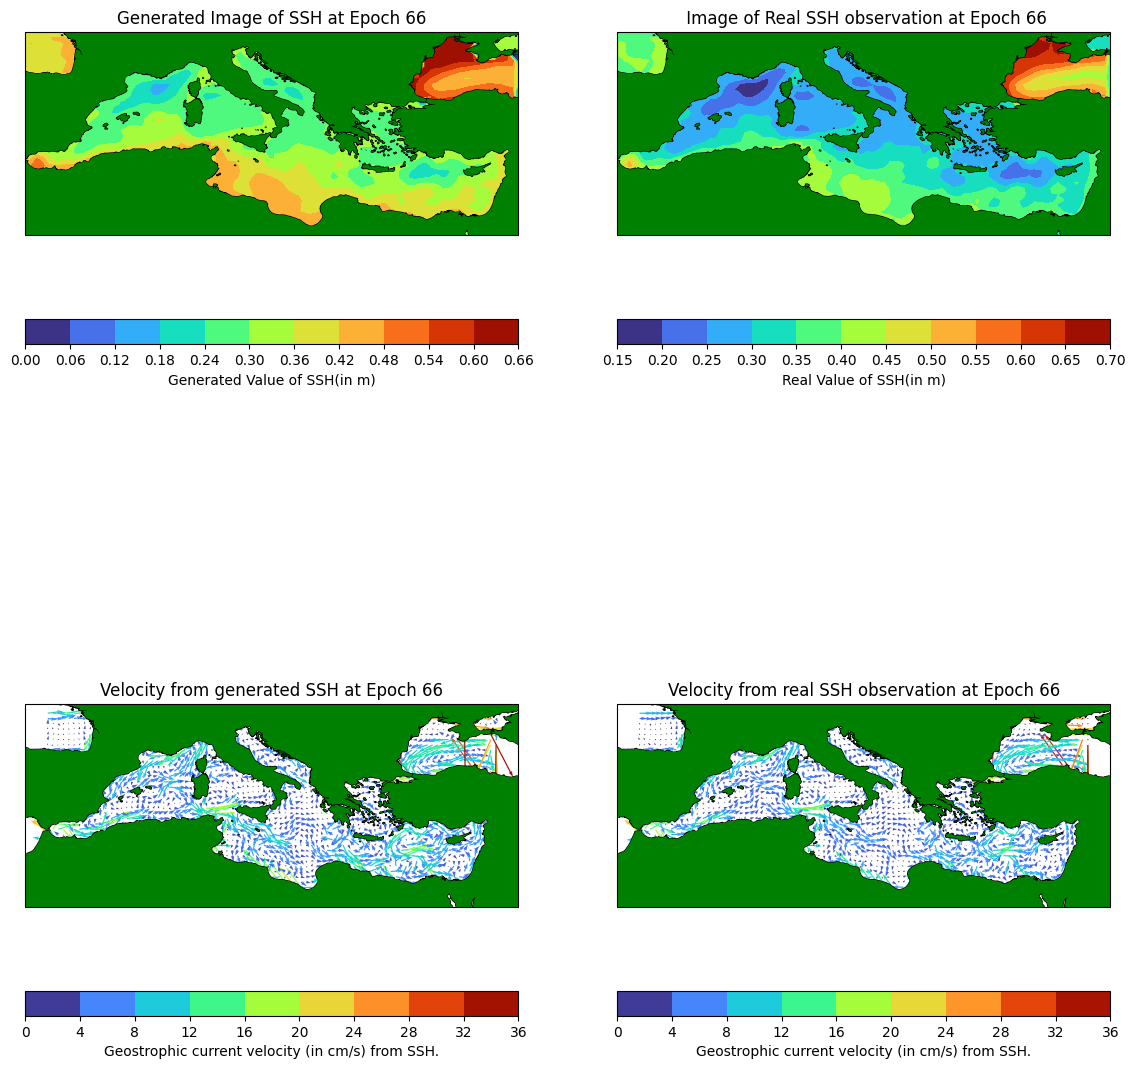

Epoch [66/100]  Loss_D: 10.0, Loss_G: 0.13498926162719727
Epoch [66/100]  Mean Loss_D: 7.621618916716186, Mean Loss_G: -0.22173641006792746
Epoch [67/100]  Mean Loss_D: 7.6959433255688054, Mean Loss_G: -0.21076427157121627
Epoch [68/100]  Mean Loss_D: 7.765763224793993, Mean Loss_G: -0.2004765393402294
Epoch [69/100]  Mean Loss_D: 7.831476071123582, Mean Loss_G: -0.19079302150138558
Epoch [70/100]  Mean Loss_D: 7.8934338976629075, Mean Loss_G: -0.1816856562239783


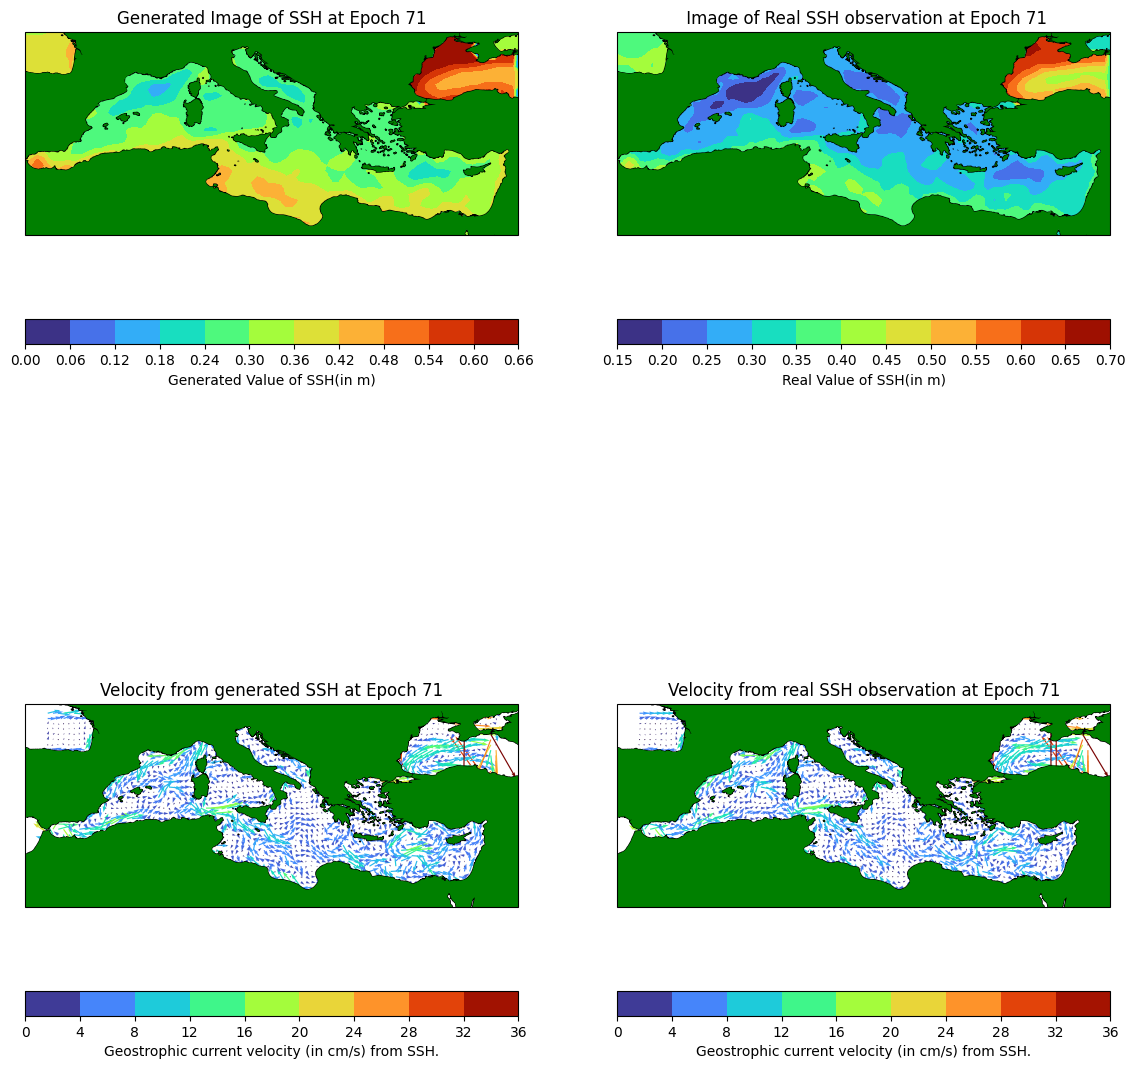

Epoch [71/100]  Loss_D: 10.0, Loss_G: 0.14990073442459106
Epoch [71/100]  Mean Loss_D: 7.9519496227278275, Mean Loss_G: -0.17307799442699462
Epoch [72/100]  Mean Loss_D: 8.007302335627076, Mean Loss_G: -0.1649565353001072
Epoch [73/100]  Mean Loss_D: 8.059741747847415, Mean Loss_G: -0.15726314764558985
Epoch [74/100]  Mean Loss_D: 8.10949195944107, Mean Loss_G: -0.14997067570964218
Epoch [75/100]  Mean Loss_D: 8.156754660455045, Mean Loss_G: -0.14303816692395643


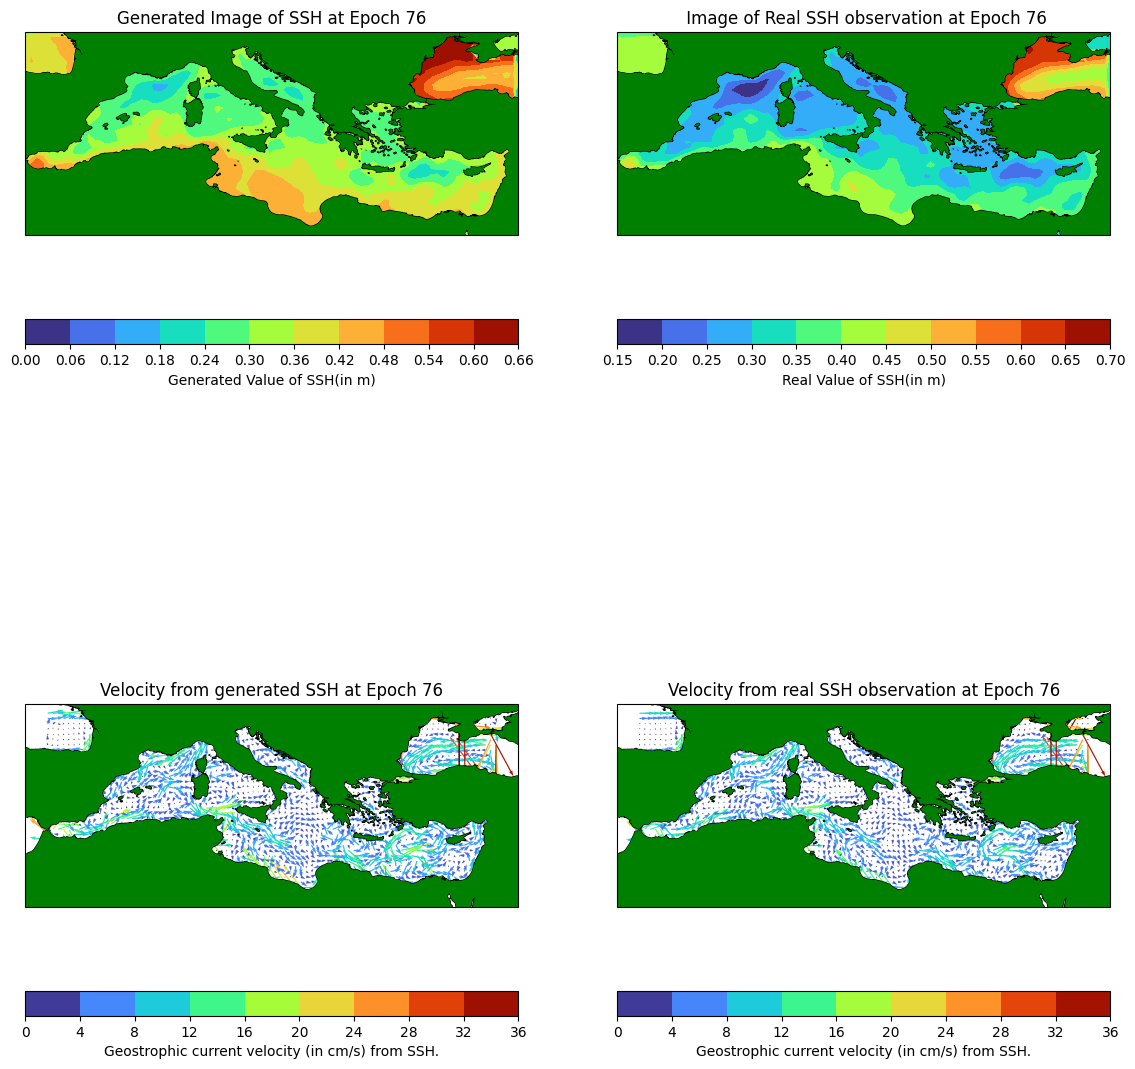

Epoch [76/100]  Loss_D: 10.0, Loss_G: 0.12767839431762695
Epoch [76/100]  Mean Loss_D: 8.20171186385858, Mean Loss_G: -0.13645319293713623
Epoch [77/100]  Mean Loss_D: 8.244528248052424, Mean Loss_G: -0.13018645290688519
Epoch [78/100]  Mean Loss_D: 8.28535317251632, Mean Loss_G: -0.12421265333953922
Epoch [79/100]  Mean Loss_D: 8.324322418595495, Mean Loss_G: -0.11852358208338092
Epoch [80/100]  Mean Loss_D: 8.361559698182262, Mean Loss_G: -0.11309593204295997


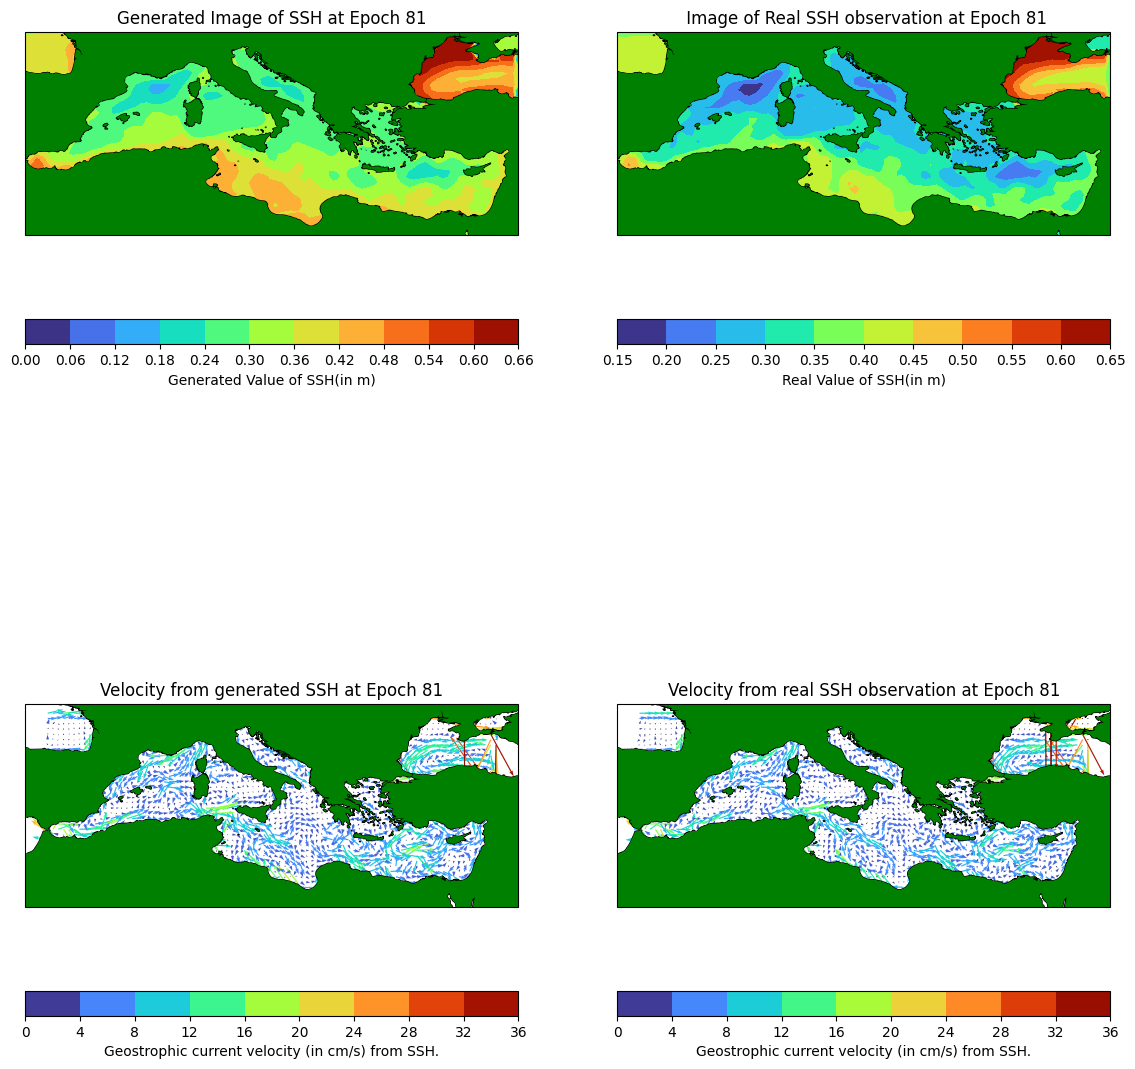

Epoch [81/100]  Loss_D: 10.0, Loss_G: 0.1420050859451294
Epoch [81/100]  Mean Loss_D: 8.397177965613082, Mean Loss_G: -0.10789872944472807
Epoch [82/100]  Mean Loss_D: 8.4312805620894, Mean Loss_G: -0.10293683176806172
Epoch [83/100]  Mean Loss_D: 8.46396221704587, Mean Loss_G: -0.09816632338545539
Epoch [84/100]  Mean Loss_D: 8.495309926902078, Mean Loss_G: -0.09360994991875757
Epoch [85/100]  Mean Loss_D: 8.525403728364035, Mean Loss_G: -0.08924826349453492


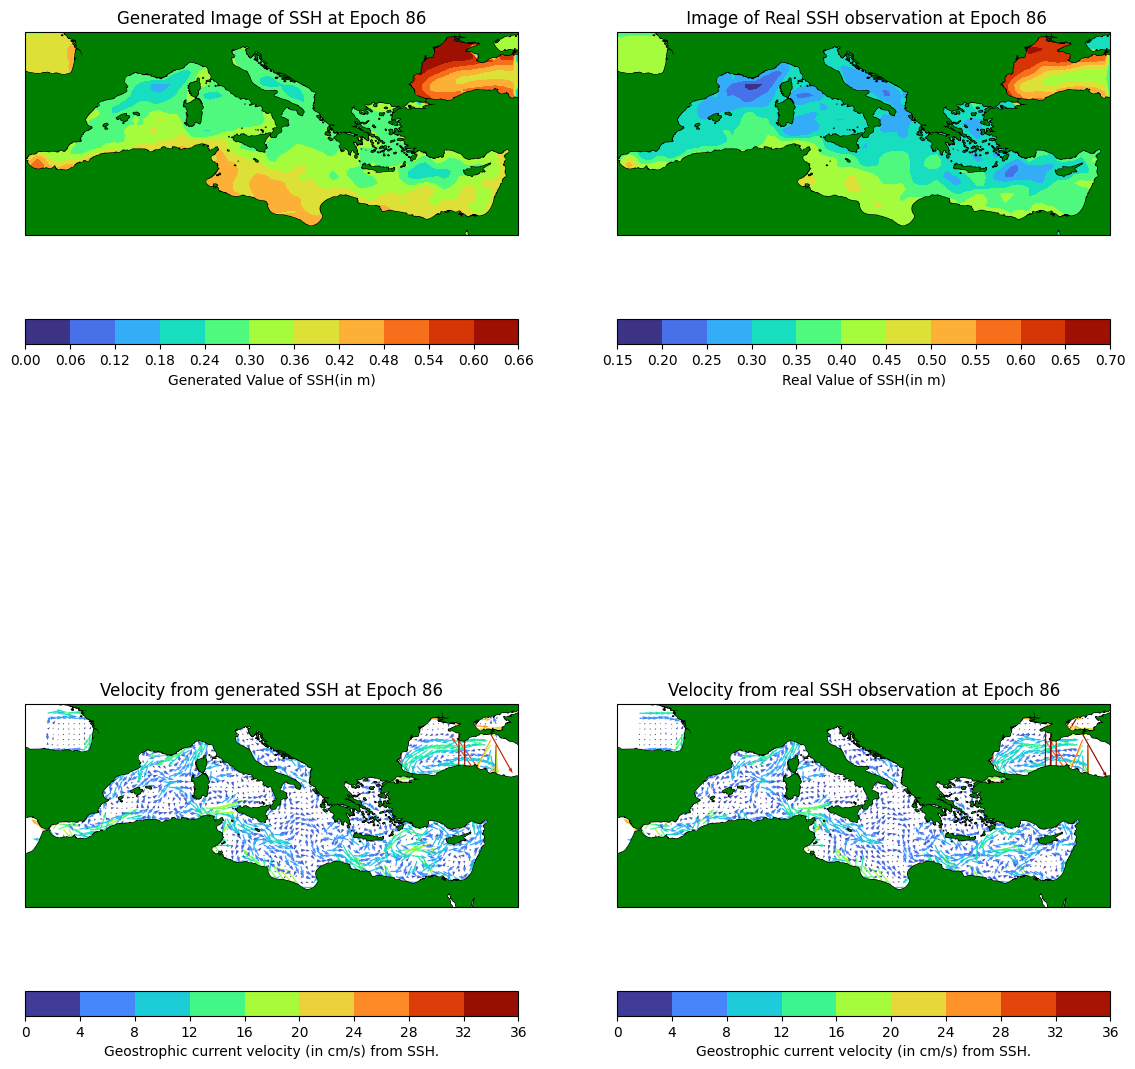

Epoch [86/100]  Loss_D: 10.0, Loss_G: 0.1549549102783203
Epoch [86/100]  Mean Loss_D: 8.554317380749055, Mean Loss_G: -0.08504882925015719
Epoch [87/100]  Mean Loss_D: 8.582118969580803, Mean Loss_G: -0.08101874889506326
Epoch [88/100]  Mean Loss_D: 8.608871441852864, Mean Loss_G: -0.07714220024198037
Epoch [89/100]  Mean Loss_D: 8.634633081818551, Mean Loss_G: -0.07341906904973566
Epoch [90/100]  Mean Loss_D: 8.659457934876396, Mean Loss_G: -0.06982365879638136


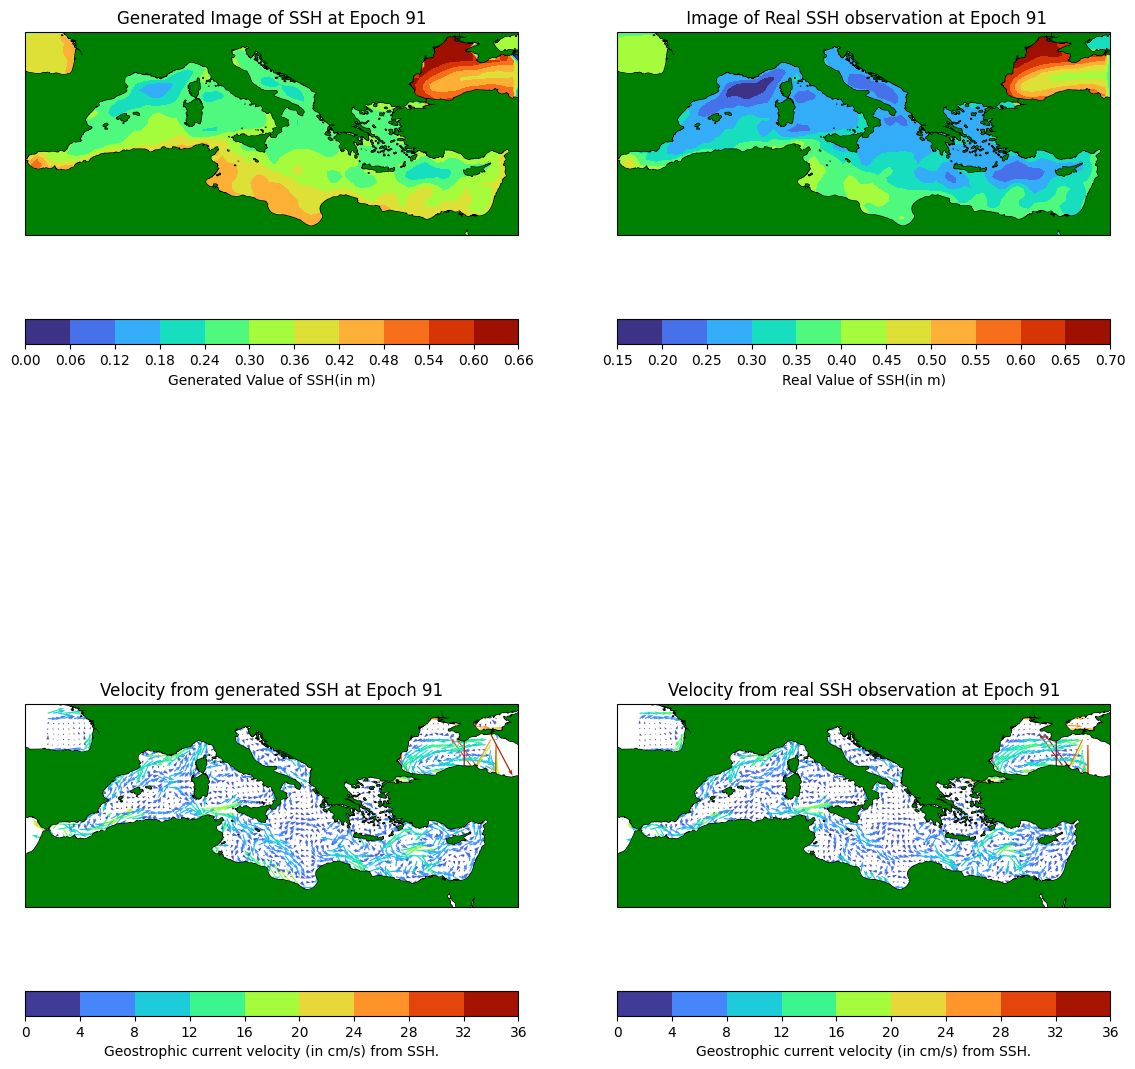

Epoch [91/100]  Loss_D: 10.0, Loss_G: 0.13775581121444702
Epoch [91/100]  Mean Loss_D: 8.683396186039317, Mean Loss_G: -0.06638095472733696
Epoch [92/100]  Mean Loss_D: 8.706494498564943, Mean Loss_G: -0.06304894666732594
Epoch [93/100]  Mean Loss_D: 8.728796317555203, Mean Loss_G: -0.05983494361833345
Epoch [94/100]  Mean Loss_D: 8.750342142681387, Mean Loss_G: -0.05672761451665352
Epoch [95/100]  Mean Loss_D: 8.771169773636696, Mean Loss_G: -0.05373212817491907


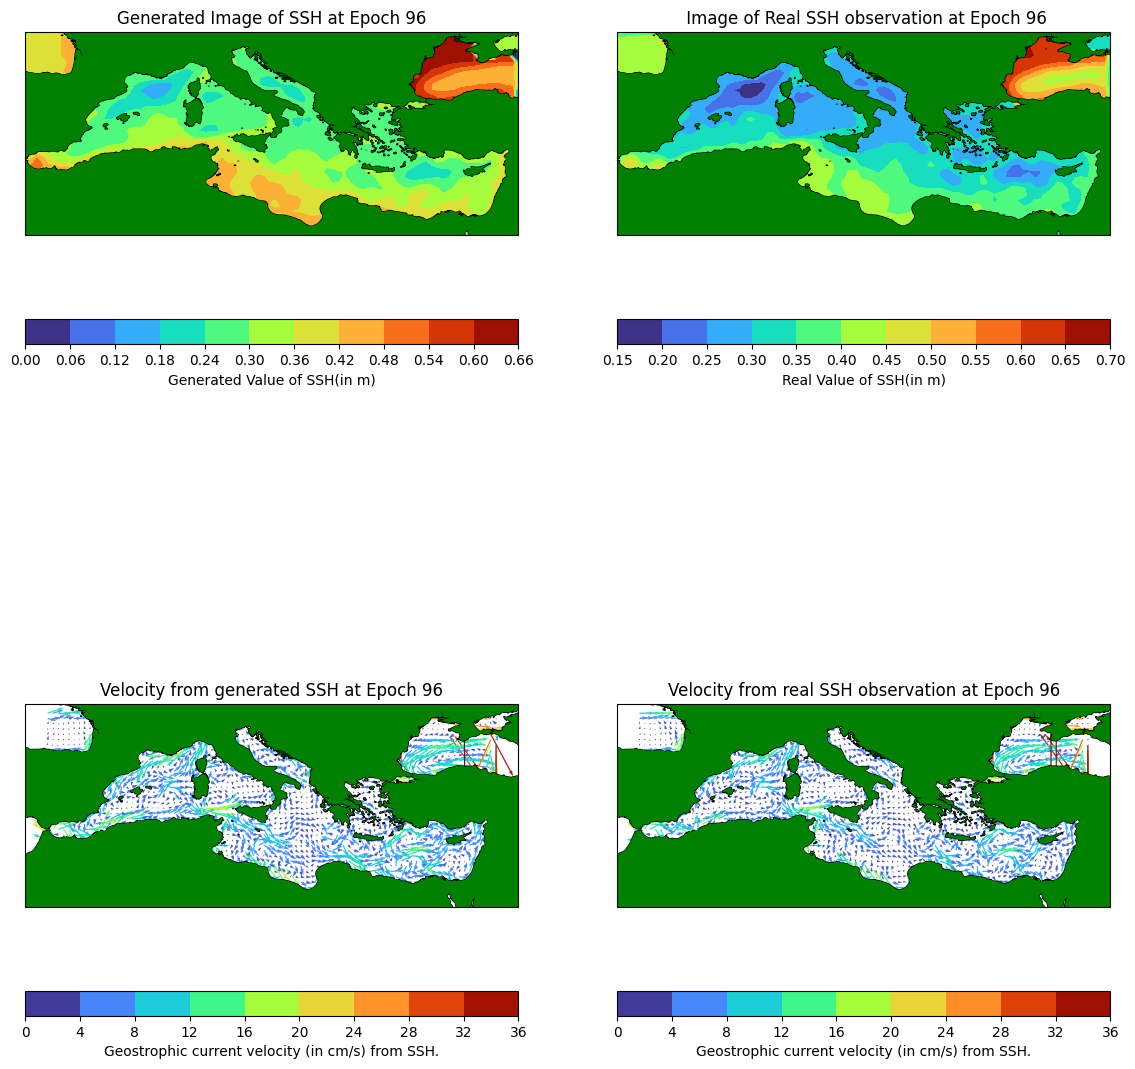

Epoch [96/100]  Loss_D: 10.0, Loss_G: 0.14607679843902588
Epoch [96/100]  Mean Loss_D: 8.79131453144593, Mean Loss_G: -0.05083326864793297
Epoch [97/100]  Mean Loss_D: 8.810809458358094, Mean Loss_G: -0.04803059063961079
Epoch [98/100]  Mean Loss_D: 8.829685498701615, Mean Loss_G: -0.045319092217805924
Epoch [99/100]  Mean Loss_D: 8.847971662784403, Mean Loss_G: -0.04271162036721679


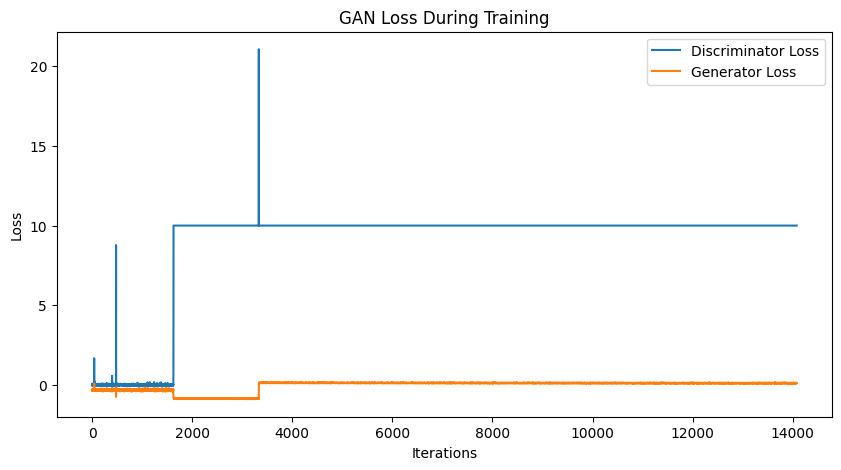

In [ ]:


# # Training function with loss tracking
def train_gan(generator, discriminator, optimizer_g, optimizer_d, epochs, batch_size, train_loader, save_interval, lambda_gp=10):
  torch.autograd.set_detect_anomaly(True)
  # print(next(iter(train_loader)).shape)

  # Lists to store loss values
  d_losses = []
  g_losses = []
  EPOCHS=[]
  d_losses_mean = []
  g_losses_mean = []

  for epoch in range(starting_epoch,epochs):
    for i,batch in enumerate(train_loader):
      # print(batch[0].shape)
      for _ in range(5):  # Train discriminator more frequently
        discriminator.zero_grad()
        real_data = batch[0][:, :, :, :86].to(device).float()  # Ensure the data is of type float32
        batch_time=batch[0][:, 0, 0, 86:].to(device)
        batch_size_real = real_data.size(0)
        real_data = real_data.view(batch_size_real, 1, 36, 86).to(device)

        noise = torch.randn(batch_size_real, input_dim, device=device)
        fake_data = generator(noise,batch_time)

        critic_real = discriminator(real_data,batch_time).view(-1)
        critic_fake = discriminator(fake_data.detach(),batch_time).view(-1)
        gp = gradient_penalty(real_data, fake_data, discriminator,batch_time, lambda_gp)

        d_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
        d_loss.backward()
        optimizer_d.step()
        EPOCHS.append(epoch+i)

      generator.zero_grad()
      noise = torch.randn(batch_size_real, input_dim, device=device)
      fake_data = generator(noise,batch_time)
      g_loss_adv = -torch.mean(discriminator(fake_data, batch_time).view(-1))
      g_loss_ssim = ssim_loss(fake_data, real_data)
      g_loss = g_loss_adv + g_loss_ssim  # Combining adversarial and SSIM losses

      g_loss.backward()
      optimizer_g.step()

      # Store losses
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())

    if (epoch+i) % save_interval == 0:
        save_image_and_models(fake_data,real_data, generator, discriminator, epoch)
        print(f'Epoch [{epoch}/{epochs}]  Loss_D: {d_loss.item()}, Loss_G: {g_loss.item()}')
    d_losses_mean.append(np.mean([dl for dl in d_losses]))
    g_losses_mean.append(np.mean([gl for gl in g_losses]))
    print(f'Epoch [{epoch}/{epochs}]  Mean Loss_D: {d_losses_mean[-1]}, Mean Loss_G: {g_losses_mean[-1]}')
  # Plot losses
  plt.figure(figsize=(10, 5))
  plt.plot(d_losses, label='Discriminator Loss')
  plt.plot(g_losses, label='Generator Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('GAN Loss During Training')
  plt.savefig(f'/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/gen_disc_training_loss_epoch_333_{epoch}.png',dpi=300)
  plt.show()
  return d_losses,g_losses,EPOCHS,g_losses_mean,d_losses_mean

def save_image_and_models(generated_data, real_image, generator, discriminator, epoch):


  mean_generated_data = generated_data.mean(dim=0)
  mean_real_data = real_image.mean(dim=0)
  if mean_generated_data.ndim==2 :

    mean_generated_data = mean_generated_data.reshape(36,86)
    mean_real_data = mean_real_data.reshape(36,86)

  image =mean_generated_data
  image = image.detach().cpu().numpy().reshape(36, 86)
  mean_real_data=mean_real_data.cpu().numpy().reshape(36, 86)
  # print(image.shape)
  # Latitude and Longitude coordinates
  latitudes = np.linspace(29.5, 47, 36)
  longitudes = np.linspace(-5.5, 37, 86)
  lon, lat = np.meshgrid(longitudes, latitudes)
  g = G(lat)
  f = fparam(lat)
  dx = 6371e3 * np.cos(np.radians(lat)) * np.radians(0.5)
  dy = 6371e3 * np.radians(0.5)

  ugeo = -(g / f) * np.gradient(image, axis=0) / dy
  vgeo = (g / f) * np.gradient(image, axis=1) / dx

  ugeo_real= -(g / f) * np.gradient(mean_real_data, axis=0) / dy
  vgeo_real = (g / f) * np.gradient(mean_real_data, axis=1) / dx

  Wfake_test=np.sqrt(ugeo**2+vgeo**2)
  Wreal_test=np.sqrt(ugeo_real**2+vgeo_real**2)

  ugeo_real[Wreal_test>0.36]=0
  vgeo_real[Wreal_test>0.36]=0
  image[Wreal_test>0.36]= 0

  ugeo[Wfake_test>0.36]=0
  vgeo[Wfake_test>0.36]=0
  image[Wfake_test>0.36]=0

  # Plotting the image on the map
  fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 16))
  ax = ax.flatten()

  ax[0].coastlines(resolution='10m')
  ax[0].add_feature(cfeature.BORDERS)
  ax[0].add_feature(cfeature.LAND, facecolor='g', zorder=2)
  ax[0].add_feature(cfeature.RIVERS)
  ax[0].add_feature(cfeature.LAKES)

  # Plotting the data
  fig1 = ax[0].contourf(lon, lat, image, levels=10, transform=ccrs.PlateCarree(), cmap='turbo')
  fig.colorbar(fig1, ax=ax[0], ticks=fig1.levels, boundaries=fig1.levels, orientation='horizontal', label='Generated Value of SSH(in m)')

  ax[0].set_title(f"Generated Image of SSH at Epoch {epoch}")

  #-------------------------------------------------------------------------------------
  ax[1].set_title(f" Image of Real SSH observation at Epoch {epoch}")
  ax[1].coastlines(resolution='10m')
  ax[1].add_feature(cfeature.BORDERS)
  ax[1].add_feature(cfeature.LAND, facecolor='g', zorder=2)
  ax[1].add_feature(cfeature.RIVERS)
  ax[1].add_feature(cfeature.LAKES)

  # Plotting the data
  fig1 = ax[1].contourf(lon, lat, mean_real_data, levels=10, transform=ccrs.PlateCarree(), cmap='turbo')
  fig.colorbar(fig1, ax=ax[1], ticks=fig1.levels, boundaries=fig1.levels, orientation='horizontal', label='Real Value of SSH(in m)')



  #--------------------------------------------------------------------------

  ax[2].coastlines(resolution='10m')
  ax[2].add_feature(cfeature.BORDERS)
  ax[2].add_feature(cfeature.LAND, facecolor='g', zorder=2)
  ax[2].add_feature(cfeature.RIVERS)
  ax[2].add_feature(cfeature.LAKES)

  ucm = 100 * ugeo
  vcm = 100 * vgeo
  Wcm = np.sqrt(ucm**2 + vcm**2)
  bounds = np.linspace(0, int(np.nanmax(Wcm))+1, 10)
  scales = 300
  if np.nanmax(Wcm) > 40:
      scales = 850
      fig2 = ax[2].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)
  else:
      scales = 350
      fig2 = ax[2].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)

  fig.colorbar(fig2, ax=ax[2], ticks=bounds, boundaries=bounds, orientation='horizontal', label='Geostrophic current velocity (in cm/s) from SSH.')

  ax[2].set_title(f"Velocity from generated SSH at Epoch {epoch}")

  #------------------------------------------------------------------------------------------------

  ax[3].coastlines(resolution='10m')
  ax[3].add_feature(cfeature.BORDERS)
  ax[3].add_feature(cfeature.LAND, facecolor='g', zorder=2)
  ax[3].add_feature(cfeature.RIVERS)
  ax[3].add_feature(cfeature.LAKES)

  ucm = 100 * ugeo_real
  vcm = 100 * vgeo_real
  Wcm = np.sqrt(ucm**2 + vcm**2)
  bounds = np.linspace(0, int(np.nanmax(Wcm))+1, 10)
  scales = 300
  if np.nanmax(Wcm) > 40:
      scales = 850
      fig3 = ax[3].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)
  else:
      scales = 350
      fig3 = ax[3].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)

  fig.colorbar(fig3, ax=ax[3], ticks=bounds, boundaries=bounds, orientation='horizontal', label='Geostrophic current velocity (in cm/s) from SSH.')

  ax[3].set_title(f"Velocity from real SSH observation at Epoch {epoch}")


  plt.savefig(f"/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/gen_image_epoch_add_noise_{epoch}.png", dpi=350)
  plt.show()

#     plt.show()

#     # Save model weights
  torch.save(generator.state_dict(), f"/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/gen_weights_epoch_333_{epoch}.pth")
  torch.save(discriminator.state_dict(), f"/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/disc_weights_epoch_333_{epoch}.pth")

# # Example usage
d_losses,g_losses,EPOCHS,g_losses_mean,d_losses_mean=train_gan(generator, discriminator,  optimizer_g, optimizer_d, epochs=100, batch_size=32, train_loader=train_loader, save_interval=5)


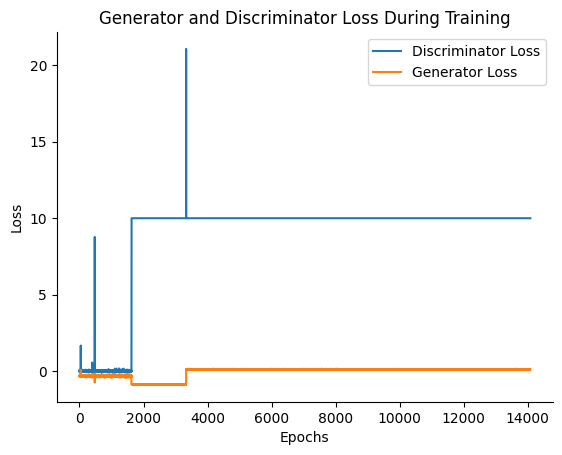

In [ ]:
plt.plot(d_losses,label='Discriminator Loss')
plt.plot(g_losses,label='Generator Loss')
plt.legend()
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.xticks)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.savefig('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/gen_disc_loss.png',dpi=300)
plt.show()

In [ ]:
array1=np.array(d_losses)
array2=np.array(g_losses)
array3=np.array(EPOCHS)
array4=np.array(g_losses_mean)
array5=np.array(d_losses_mean)

In [ ]:
np.save('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/d_losses.npy',array1)
np.save('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/g_losses.npy',array2)
np.save('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/EPOCHS.npy',array3)
np.save('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/g_losses_mean.npy',array4)
np.save('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/d_losses_mean.npy',array5)

In [ ]:
import logging

logging.basicConfig(filename='/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/training.log',level=logging.INFO)
logging.info('starting training')



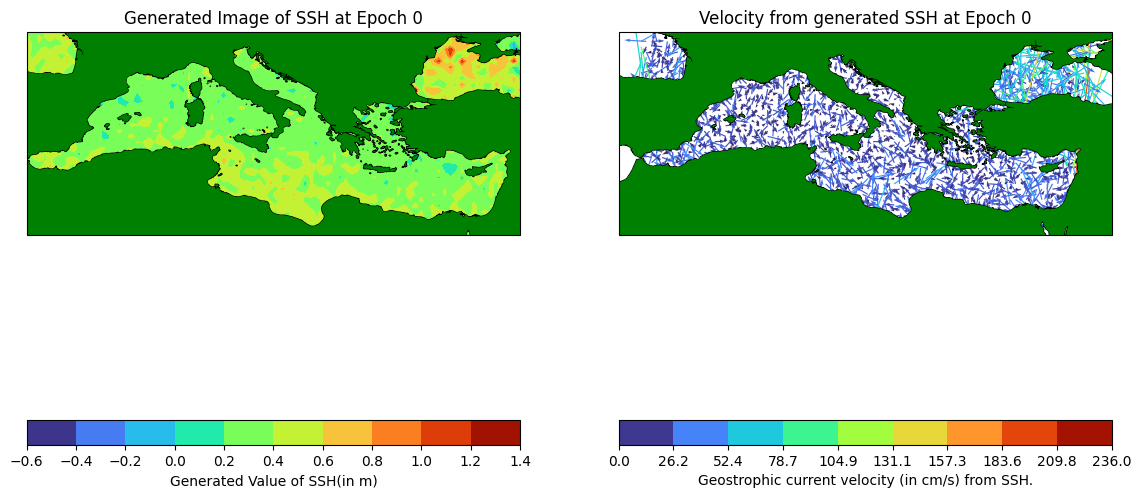

Epoch [0/100]  Loss_D: 0.1618182212114334, Loss_G: -0.420065701007843


In [ ]:


# Training function with loss tracking
def train_gan(generator, discriminator, optimizer_g, optimizer_d, epochs, batch_size, train_loader, save_interval, lambda_gp=10):
    torch.autograd.set_detect_anomaly(True)

    # Lists to store loss values
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        for i,batch in enumerate(train_loader):
          # for _ in range(5):  # Train discriminator more frequently
          discriminator.zero_grad()
          # print(batch[0].shape)
          # data_per_batch=batch[0]
          # print(data_per_batch.shape)
          real_data = batch[0][:, :, :, :86].to(device).float()  # Ensure the data is of type float32
          batch_time=batch[0][:, 0, 0, 86:].to(device)
          batch_size_real = real_data.size(0)
          real_data = real_data.view(batch_size_real, 1, 36, 86).to(device)

          noise = torch.randn(batch_size_real, input_dim, device=device)
          fake_data = generator(noise,batch_time)

          critic_real = discriminator(real_data,batch_time).view(-1)
          critic_fake = discriminator(fake_data.detach(),batch_time).view(-1)
          gp = gradient_penalty(real_data, fake_data, discriminator,batch_time, lambda_gp)

          d_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
          d_loss.backward()
          optimizer_d.step()

          generator.zero_grad()
          noise = torch.randn(batch_size_real, input_dim, device=device)
          fake_data = generator(noise,batch_time)
          g_loss = -torch.mean(discriminator(fake_data,batch_time).view(-1))
          g_loss.backward()
          optimizer_g.step()

          # Store losses
          d_losses.append(d_loss.item())
          g_losses.append(g_loss.item())

        if epoch % save_interval == 0:
            save_image_and_models(fake_data, generator, discriminator, epoch)
            print(f'Epoch [{epoch}/{epochs}]  Loss_D: {d_loss.item()}, Loss_G: {g_loss.item()}')

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Loss During Training')
    plt.show()

def save_image_and_models(generated_data, generator, discriminator, epoch):
    # Save the generated image
    image = generated_data[0]
    # print('the shaped image is:', image.shape)  # Debugging statement
    image = image.detach().cpu().numpy().reshape(36, 86)

    # Latitude and Longitude coordinates
    latitudes = np.linspace(29.5, 47, 36)
    longitudes = np.linspace(-5.5, 37, 86)
    lon, lat = np.meshgrid(longitudes, latitudes)
    g = G(lat)
    f = fparam(lat)
    dx = 6371e3 * np.cos(np.radians(lat)) * np.radians(0.5)
    dy = 6371e3 * np.radians(0.5)

    ugeo = -(g / f) * np.gradient(image, axis=0) / dy
    vgeo = (g / f) * np.gradient(image, axis=1) / dx

    # Plotting the image on the map
    fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 16))
    ax = ax.flatten()

    ax[0].coastlines(resolution='10m')
    ax[0].add_feature(cfeature.BORDERS)
    ax[0].add_feature(cfeature.LAND, facecolor='g', zorder=2)
    ax[0].add_feature(cfeature.RIVERS)
    ax[0].add_feature(cfeature.LAKES)

    # Plotting the data
    fig1 = ax[0].contourf(lon, lat, image, levels=10, transform=ccrs.PlateCarree(), cmap='turbo')
    fig.colorbar(fig1, ax=ax[0], ticks=fig1.levels, boundaries=fig1.levels, orientation='horizontal', label='Generated Value of SSH(in m)')

    ax[0].set_title(f"Generated Image of SSH at Epoch {epoch}")

    ax[1].coastlines(resolution='10m')
    ax[1].add_feature(cfeature.BORDERS)
    ax[1].add_feature(cfeature.LAND, facecolor='g', zorder=2)
    ax[1].add_feature(cfeature.RIVERS)
    ax[1].add_feature(cfeature.LAKES)

    ucm = 100 * ugeo
    vcm = 100 * vgeo
    Wcm = np.sqrt(ucm**2 + vcm**2)
    bounds=np.linspace(0,int(np.nanmax(Wcm))+1,10)
    scales = 300
    # ucm[np.logical_and(np.nanmax(Wcm)>36,epoch>15)]=0
    # vcm[np.logical_and(np.nanmax(Wcm)>36,epoch>15)]=0
    # Wcm[np.logical_and(np.nanmax(Wcm)>36,epoch>15)]=0
    if np.nanmax(Wcm) > 40:
        scales = 850
        fig2 = ax[1].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)
    else:
        scales = 350
        fig2 = ax[1].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)

    fig.colorbar(fig2, ax=ax[1], ticks=bounds, boundaries=bounds, orientation='horizontal', label='Geostrophic current velocity (in cm/s) from SSH.')

    ax[1].set_title(f"Velocity from generated SSH at Epoch {epoch}")

    plt.savefig(f"/content/MyDrive/MyDrive/GAN_DATA/filtered_mutant/ssh-gan/LEARNING_RATE_CHANGE/generated_image_epoch_add_noise112_{epoch}.png", dpi=350)
    plt.show()

    # Save model weights
    torch.save(generator.state_dict(), f"/content/MyDrive/MyDrive/GAN_DATA/filtered_mutant/ssh-gan/LEARNING_RATE_CHANGE/generator_weights_epoch_add_noise112_{epoch}.pth")
    torch.save(discriminator.state_dict(), f"/content/MyDrive/MyDrive/GAN_DATA/filtered_mutant/ssh-gan/LEARNING_RATE_CHANGE/discriminator_weights_add_noise112_{epoch}.pth")

# Example usage
train_gan(generator, discriminator,  optimizer_g, optimizer_d, epochs=100, batch_size=16, train_loader=train_loader, save_interval=5)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.7 MB/s eta 0:00:00


In [ ]:
ssim_loss = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [ ]:
def gradient_penalty(real_data, fake_data, discriminator, batch_time, lambda_gp=10):
    alpha = torch.rand(real_data.size(0), 1, 1, 1, device=device).expand_as(real_data)
    interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    interpolated_critic = discriminator(interpolated, batch_time)

    grad_outputs = torch.ones(interpolated_critic.size(), device=device)
    gradients = torch.autograd.grad(
        outputs=interpolated_critic,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = lambda_gp * ((gradient_norm - 1) ** 2).mean()
    return penalty


In [ ]:


# # Training function with loss tracking
def train_gan(generator, discriminator, optimizer_g, optimizer_d, epochs, batch_size, train_loader, save_interval, lambda_gp=10):
  torch.autograd.set_detect_anomaly(True)
  # print(next(iter(train_loader)).shape)

  # Lists to store loss values
  d_losses = []
  g_losses = []
  EPOCHS=[]

  for epoch in range(starting_epoch,epochs):
    for i,batch in enumerate(train_loader):
      # print(batch[0].shape)
      for _ in range(5):  # Train discriminator more frequently
        discriminator.zero_grad()
        real_data = batch[0][:, :, :, :86].to(device).float()  # Ensure the data is of type float32
        batch_time=batch[0][:, 0, 0, 86:].to(device)
        batch_size_real = real_data.size(0)
        real_data = real_data.view(batch_size_real, 1, 36, 86).to(device)

        noise = torch.randn(batch_size_real, input_dim, device=device)
        fake_data = generator(noise,batch_time)

        critic_real = discriminator(real_data,batch_time).view(-1)
        critic_fake = discriminator(fake_data.detach(),batch_time).view(-1)
        gp = gradient_penalty(real_data, fake_data, discriminator,batch_time, lambda_gp)

        d_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
        d_loss.backward()
        optimizer_d.step()
        EPOCHS.append(epoch+i)

      generator.zero_grad()
      noise = torch.randn(batch_size_real, input_dim, device=device)
      fake_data = generator(noise,batch_time)
      g_loss_adv = -torch.mean(discriminator(fake_data, batch_time).view(-1))
      g_loss_ssim = ssim_loss(fake_data, real_data)
      g_loss = g_loss_adv + g_loss_ssim  # Combining adversarial and SSIM losses

      g_loss.backward()
      optimizer_g.step()

      # Store losses
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())

      if (epoch+i) % save_interval == 0:
          save_image_and_models(fake_data,real_data, generator, discriminator, epoch)
          print(f'Epoch [{epoch}/{epochs}]  Loss_D: {d_loss.item()}, Loss_G: {g_loss.item()}')

  # Plot losses
  plt.figure(figsize=(10, 5))
  plt.plot(d_losses, label='Discriminator Loss')
  plt.plot(g_losses, label='Generator Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('GAN Loss During Training')
  plt.savefig(f'/content/MyDrive/MyDrive/GAN_DATA/filtered_mutant/ssh-gan/LEARNING_RATE_CHANGE/generator_discriminator_training_loss_epoch_333_{epoch}.png',dpi=300)
  plt.show()

def save_image_and_models(generated_data, real_image, generator, discriminator, epoch):


  mean_generated_data = generated_data.mean(dim=0)
  mean_real_data = real_image.mean(dim=0)
  if mean_generated_data.ndim==2 :

    mean_generated_data = mean_generated_data.reshape(36,86)
    mean_real_data = mean_real_data.reshape(36,86)

  image =mean_generated_data
  image = image.detach().cpu().numpy().reshape(36, 86)
  mean_real_data=mean_real_data.cpu().numpy().reshape(36, 86)
  # print(image.shape)
  # Latitude and Longitude coordinates
  latitudes = np.linspace(29.5, 47, 36)
  longitudes = np.linspace(-5.5, 37, 86)
  lon, lat = np.meshgrid(longitudes, latitudes)
  g = G(lat)
  f = fparam(lat)
  dx = 6371e3 * np.cos(np.radians(lat)) * np.radians(0.5)
  dy = 6371e3 * np.radians(0.5)

  ugeo = -(g / f) * np.gradient(image, axis=0) / dy
  vgeo = (g / f) * np.gradient(image, axis=1) / dx

  ugeo_real= -(g / f) * np.gradient(mean_real_data, axis=0) / dy
  vgeo_real = (g / f) * np.gradient(mean_real_data, axis=1) / dx

  Wfake_test=np.sqrt(ugeo**2+vgeo**2)
  Wreal_test=np.sqrt(ugeo_real**2+vgeo_real**2)

  ugeo_real[Wreal_test>0.36]=0
  vgeo_real[Wreal_test>0.36]=0
  image[Wreal_test>0.36]= 0

  ugeo[Wfake_test>0.36]=0
  vgeo[Wfake_test>0.36]=0
  image[Wfake_test>0.36]=0

  # Plotting the image on the map
  fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 16))
  ax = ax.flatten()

  ax[0].coastlines(resolution='10m')
  ax[0].add_feature(cfeature.BORDERS)
  ax[0].add_feature(cfeature.LAND, facecolor='g', zorder=2)
  ax[0].add_feature(cfeature.RIVERS)
  ax[0].add_feature(cfeature.LAKES)

  # Plotting the data
  fig1 = ax[0].contourf(lon, lat, image, levels=10, transform=ccrs.PlateCarree(), cmap='turbo')
  fig.colorbar(fig1, ax=ax[0], ticks=fig1.levels, boundaries=fig1.levels, orientation='horizontal', label='Generated Value of SSH(in m)')

  ax[0].set_title(f"Generated Image of SSH at Epoch {epoch}")

  #-------------------------------------------------------------------------------------
  ax[1].set_title(f"Generated Image of SSH at Epoch {epoch}")
  ax[1].coastlines(resolution='10m')
  ax[1].add_feature(cfeature.BORDERS)
  ax[1].add_feature(cfeature.LAND, facecolor='g', zorder=2)
  ax[1].add_feature(cfeature.RIVERS)
  ax[1].add_feature(cfeature.LAKES)

  # Plotting the data
  fig1 = ax[1].contourf(lon, lat, mean_real_data, levels=10, transform=ccrs.PlateCarree(), cmap='turbo')
  fig.colorbar(fig1, ax=ax[1], ticks=fig1.levels, boundaries=fig1.levels, orientation='horizontal', label='Real Value of SSH(in m)')



  #--------------------------------------------------------------------------

  ax[2].coastlines(resolution='10m')
  ax[2].add_feature(cfeature.BORDERS)
  ax[2].add_feature(cfeature.LAND, facecolor='g', zorder=2)
  ax[2].add_feature(cfeature.RIVERS)
  ax[2].add_feature(cfeature.LAKES)

  ucm = 100 * ugeo
  vcm = 100 * vgeo
  Wcm = np.sqrt(ucm**2 + vcm**2)
  bounds = np.linspace(0, int(np.nanmax(Wcm))+1, 10)
  scales = 300
  if np.nanmax(Wcm) > 40:
      scales = 850
      fig2 = ax[2].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)
  else:
      scales = 350
      fig2 = ax[2].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)

  fig.colorbar(fig2, ax=ax[2], ticks=bounds, boundaries=bounds, orientation='horizontal', label='Geostrophic current velocity (in cm/s) from SSH.')

  ax[2].set_title(f"Velocity from generated SSH at Epoch {epoch}")

  #------------------------------------------------------------------------------------------------

  ax[3].coastlines(resolution='10m')
  ax[3].add_feature(cfeature.BORDERS)
  ax[3].add_feature(cfeature.LAND, facecolor='g', zorder=2)
  ax[3].add_feature(cfeature.RIVERS)
  ax[3].add_feature(cfeature.LAKES)

  ucm = 100 * ugeo_real
  vcm = 100 * vgeo_real
  Wcm = np.sqrt(ucm**2 + vcm**2)
  bounds = np.linspace(0, int(np.nanmax(Wcm))+1, 10)
  scales = 300
  if np.nanmax(Wcm) > 40:
      scales = 850
      fig3 = ax[3].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)
  else:
      scales = 350
      fig3 = ax[3].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)

  fig.colorbar(fig3, ax=ax[3], ticks=bounds, boundaries=bounds, orientation='horizontal', label='Geostrophic current velocity (in cm/s) from SSH.')

  ax[3].set_title(f"Velocity from generated SSH at Epoch {epoch}")


  plt.savefig(f"/content/MyDrive/MyDrive/GAN_DATA/filtered_mutant/ssh-gan/LEARNING_RATE_CHANGE/generated_image_epoch_add_noise_{epoch}.png", dpi=350)
  plt.show()

#     plt.show()

#     # Save model weights
  torch.save(generator.state_dict(), f"/content/MyDrive/MyDrive/GAN_DATA/filtered_mutant/ssh-gan/LEARNING_RATE_CHANGE/generator_weights_epoch_333_{epoch}.pth")
  torch.save(discriminator.state_dict(), f"/content/MyDrive/MyDrive/GAN_DATA/filtered_mutant/ssh-gan/LEARNING_RATE_CHANGE/discriminator_weights_epoch_333_{epoch}.pth")

# # Example usage
train_gan(generator, discriminator,  optimizer_g, optimizer_d, epochs=100, batch_size=32, train_loader=train_loader, save_interval=5)


NameError: name 'generator' is not defined

In [ ]:

Training_loss=[(0,  'Loss_D:', -0.009828679263591766, 'Loss_G:', -0.3858538568019867),
  (5,  'Loss_D:', -0.2087317854166031, 'Loss_G:', -0.3668328523635864),
  (10,  'Loss_D:',  -0.2574380040168762, 'Loss_G:', -0.3013441860675812),
  (15,  'Loss_D:',   -0.36910179257392883, 'Loss_G:', -0.30117639899253845),
 (20,  'Loss_D:',  -0.3834837079048157, 'Loss_G:', -0.41698184609413147),
                ]

In [ ]:
# prompt: generate dataframe for this list
# Training_loss=[('Epoch [0/100]',  'Loss_D:', -0.009828679263591766, 'Loss_G:', -0.3858538568019867),
#   ('Epoch [5/100]',  'Loss_D:', -0.2087317854166031, 'Loss_G:', -0.3668328523635864),
#   ('Epoch [10/100]',  'Loss_D:',  -0.2574380040168762, 'Loss_G:', -0.3013441860675812),
#   ('Epoch [15/100]',  'Loss_D:',   -0.36910179257392883, 'Loss_G:', -0.30117639899253845),

import pandas as pd

# Create a list of dictionaries, where each dictionary represents a row in the dataframe
data = [
    {'Epoch': row[0], 'Loss_D': row[2], 'Loss_G': row[4]}
    for row in Training_loss
]

# Create the dataframe
df = pd.DataFrame(data)

# Print the dataframe
df


Epoch    Loss_D    Loss_G
0      0 -0.009829 -0.385854
1      5 -0.208732 -0.366833
2     10 -0.257438 -0.301344
3     15 -0.369102 -0.301176
4     20 -0.383484 -0.416982

<Axes: xlabel='Epoch'>

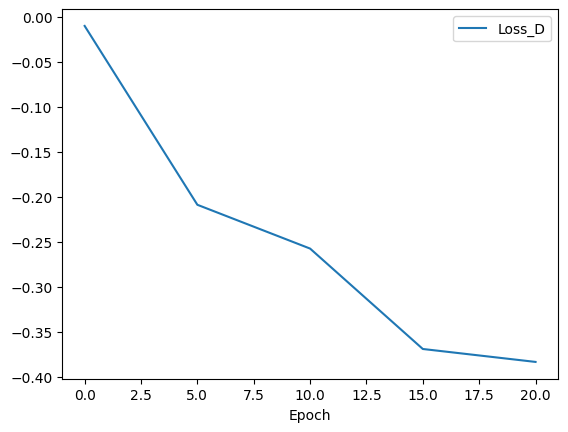

In [ ]:
df.plot(x='Epoch',y='Loss_D')

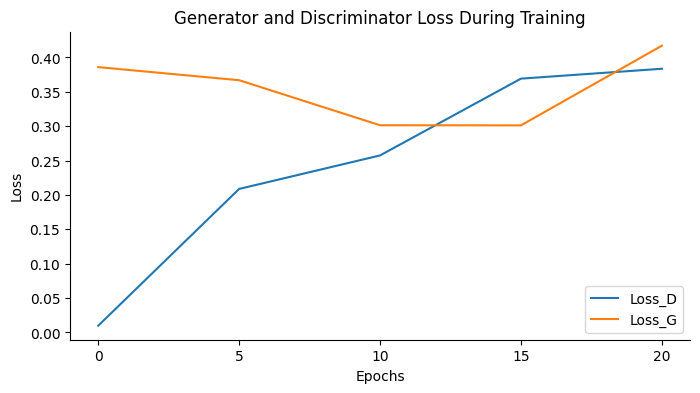

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=[8,4])
plt.plot(df['Epoch'],-df['Loss_D'],label='Loss_D')
plt.plot(df['Epoch'],-df['Loss_G'],label='Loss_G')
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(df['Epoch'])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.savefig('/content/MyDrive/MyDrive/GAN_DATA/filtered_mutant/ssh-gan/WGAN-USAGE/gen_disc_loss.png',dpi=300)

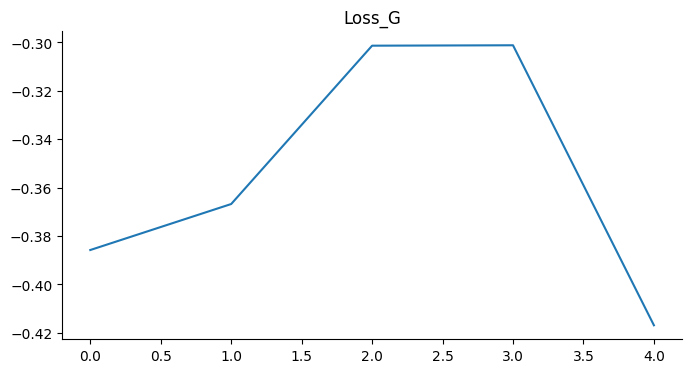

In [ ]:


plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
path='/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/LEARNING_RATE_CHANGE/gen_weights_epoch_333_96.pth'

In [ ]:
states=torch.load(path,map_location=torch.device('cpu'))
for key, params in states.items():
    print(key,'=====>', params.shape)

module.fc.0.model.0.weight =====> torch.Size([214, 214])
module.fc.0.model.0.bias =====> torch.Size([214])
module.fc.0.model.2.weight =====> torch.Size([214, 214])
module.fc.0.model.2.bias =====> torch.Size([214])
module.fc.0.model.4.weight =====> torch.Size([214, 214])
module.fc.0.model.4.bias =====> torch.Size([214])
module.fc.0.model.6.weight =====> torch.Size([214, 214])
module.fc.0.model.6.bias =====> torch.Size([214])
module.fc.1.weight =====> torch.Size([24192, 214])
module.fc.1.bias =====> torch.Size([24192])
module.deconv.0.weight =====> torch.Size([128])
module.deconv.0.bias =====> torch.Size([128])
module.deconv.0.running_mean =====> torch.Size([128])
module.deconv.0.running_var =====> torch.Size([128])
module.deconv.0.num_batches_tracked =====> torch.Size([])
module.deconv.1.weight =====> torch.Size([128, 256, 4, 5])
module.deconv.1.bias =====> torch.Size([256])
module.deconv.2.weight =====> torch.Size([256])
module.deconv.2.bias =====> torch.Size([256])
module.deconv.2.run

In [ ]:
for key, params in states.items():
    print(key,'=====>', params.shape)


fc.0.model.0.weight =====> torch.Size([214, 214])
fc.0.model.0.bias =====> torch.Size([214])
fc.0.model.2.weight =====> torch.Size([214, 214])
fc.0.model.2.bias =====> torch.Size([214])
fc.0.model.4.weight =====> torch.Size([214, 214])
fc.0.model.4.bias =====> torch.Size([214])
fc.0.model.6.weight =====> torch.Size([214, 214])
fc.0.model.6.bias =====> torch.Size([214])
fc.1.weight =====> torch.Size([24192, 214])
fc.1.bias =====> torch.Size([24192])
deconv.0.weight =====> torch.Size([128])
deconv.0.bias =====> torch.Size([128])
deconv.0.running_mean =====> torch.Size([128])
deconv.0.running_var =====> torch.Size([128])
deconv.0.num_batches_tracked =====> torch.Size([])
deconv.1.weight =====> torch.Size([128, 256, 4, 5])
deconv.1.bias =====> torch.Size([256])
deconv.2.weight =====> torch.Size([256])
deconv.2.bias =====> torch.Size([256])
deconv.2.running_mean =====> torch.Size([256])
deconv.2.running_var =====> torch.Size([256])
deconv.2.num_batches_tracked =====> torch.Size([])
deconv.4

In [ ]:
states=torch.load(path)

In [ ]:
generator = Generator(input_dim=200,n_layers=4,temporaly_dim=temporaly_dim).to(device)

In [ ]:
generator

Generator(
  (fc): Sequential(
    (0): Mapping_Network(
      (model): Sequential(
        (0): Linear(in_features=214, out_features=214, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=214, out_features=214, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=214, out_features=214, bias=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=214, out_features=214, bias=True)
      )
    )
    (1): Linear(in_features=214, out_features=24192, bias=True)
    (2): ReLU(inplace=True)
  )
  (deconv): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(128, 256, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), output_padding=(0, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
for name, param in generator.named_parameters():
    print(name)

fc.0.model.0.weight
fc.0.model.0.bias
fc.0.model.2.weight
fc.0.model.2.bias
fc.0.model.4.weight
fc.0.model.4.bias
fc.0.model.6.weight
fc.0.model.6.bias
fc.1.weight
fc.1.bias
deconv.0.weight
deconv.0.bias
deconv.1.weight
deconv.1.bias
deconv.2.weight
deconv.2.bias
deconv.4.conv1.weight
deconv.4.conv1.bias
deconv.4.conv2.weight
deconv.4.conv2.bias
deconv.5.weight
deconv.5.bias
deconv.6.weight
deconv.6.bias
deconv.8.conv1.weight
deconv.8.conv1.bias
deconv.8.conv2.weight
deconv.8.conv2.bias
deconv.9.gamma
deconv.9.query_conv.weight
deconv.9.query_conv.bias
deconv.9.key_conv.weight
deconv.9.key_conv.bias
deconv.9.value_conv.weight
deconv.9.value_conv.bias
deconv.10.weight
deconv.10.bias
deconv.11.weight
deconv.11.bias
deconv.13.conv1.weight
deconv.13.conv1.bias
deconv.13.conv2.weight
deconv.13.conv2.bias
deconv.14.weight
deconv.14.bias
deconv.15.weight
deconv.15.bias
deconv.17.conv1.weight
deconv.17.conv1.bias
deconv.17.conv2.weight
deconv.17.conv2.bias
deconv.18.gamma
deconv.18.query_conv.

In [ ]:
for name ,param in states.items():
  print(name)


module.fc.0.model.0.weight
module.fc.0.model.0.bias
module.fc.0.model.2.weight
module.fc.0.model.2.bias
module.fc.0.model.4.weight
module.fc.0.model.4.bias
module.fc.0.model.6.weight
module.fc.0.model.6.bias
module.fc.1.weight
module.fc.1.bias
module.deconv.0.weight
module.deconv.0.bias
module.deconv.0.running_mean
module.deconv.0.running_var
module.deconv.0.num_batches_tracked
module.deconv.1.weight
module.deconv.1.bias
module.deconv.2.weight
module.deconv.2.bias
module.deconv.2.running_mean
module.deconv.2.running_var
module.deconv.2.num_batches_tracked
module.deconv.4.conv1.weight
module.deconv.4.conv1.bias
module.deconv.4.conv2.weight
module.deconv.4.conv2.bias
module.deconv.5.weight
module.deconv.5.bias
module.deconv.6.weight
module.deconv.6.bias
module.deconv.6.running_mean
module.deconv.6.running_var
module.deconv.6.num_batches_tracked
module.deconv.8.conv1.weight
module.deconv.8.conv1.bias
module.deconv.8.conv2.weight
module.deconv.8.conv2.bias
module.deconv.9.gamma
module.deco

In [ ]:
from collections import OrderedDict

# Strip the 'module.' prefix
new_state_dict = OrderedDict()
for k, v in states.items():
    name = k[7:] if k.startswith('module.') else k  # Remove `module.` if it exists
    new_state_dict[name] = v
    
# Load the generator model

generator.load_state_dict(new_state_dict)#,map_location=torch.device('cpu')
generator.eval() 

In [ ]:
# Load the generator model

generator.load_state_dict(new_state_dict)#,map_location=torch.device('cpu')
generator.eval()  # S

Generator(
  (fc): Sequential(
    (0): Mapping_Network(
      (model): Sequential(
        (0): Linear(in_features=214, out_features=214, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=214, out_features=214, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=214, out_features=214, bias=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=214, out_features=214, bias=True)
      )
    )
    (1): Linear(in_features=214, out_features=24192, bias=True)
    (2): ReLU(inplace=True)
  )
  (deconv): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(128, 256, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), output_padding=(0, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
# Save the generator model
torch.save(generator.state_dict(), "final_generator_weights.pth")

# Load the generator model
generator = Generator(input_dim=200,n_layers=4).to(device)
generator.load_state_dict(torch.load("final_generator_weights.pth"))
generator.eval()  # Set the generator to evaluation mode


Generator(
  (fc): Sequential(
    (0): Mapping_Network(
      (model): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=200, out_features=200, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=200, out_features=200, bias=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=200, out_features=200, bias=True)
      )
    )
    (1): Linear(in_features=200, out_features=24192, bias=True)
    (2): ReLU(inplace=True)
  )
  (deconv): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(128, 256, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), output_padding=(0, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
# # Reload the generator model
# input_dim = 200
# generator = Generator(input_dim,n_layers=4).to(device)
# generator.load_state_dict(torch.load("final_generator_weights.pth"))
# generator.eval()  # Set the generator to evaluation mode


In [ ]:
# def generate_synthetic_data(generator, num_samples, input_dim,validation_loader):
#     generator.eval()  # Ensure the generator is in evaluation mode
#     noise = torch.randn(num_samples, input_dim).to(device)
#     with torch.no_grad():
#         synthetic_data = generator(noise)
#     return synthetic_data

# # Generate synthetic data samples
# num_samples = 5
# synthetic_data = generate_synthetic_data(generator, num_samples, input_dim=86)


In [ ]:
len(validation_loader)

7

In [ ]:
def dropvars(data,quantile):

  quantile_var=np.quantile(data,quantile/100,keepdims=True)
  mask=data<=quantile_var

  return data*mask

In [ ]:
dropvars(data=np.array([[1,3,4,9,34,86]]),quantile=95)

array([[ 1,  3,  4,  9, 34,  0]])

In [ ]:


# Assuming generator and discriminator are already defined and trained

# Function to generate and visualize samples
def generate_samples(generator, num_samples, input_dim, device,validation_set):
  All_generated_data=[]
  generator.eval()
  with torch.no_grad():
        # Generate random noise

        # Generate fake data

    for i,batch in enumerate(validation_set):

      # print('The shape of the batch is: ',batch[0].shape)
      real_data = batch[0][:, :, :, :86].to(device).float()  # Ensure the data is of type float32
      batch_time=batch[0][:, 0, 0, 86:].to(device)
      noise = torch.randn(batch_time.shape[0], input_dim, device=device)
      print('the noise and time data shape is: ',noise.shape,batch_time.shape)
      x=torch.cat((noise,batch_time),dim=1)
      fake_data = generator(noise,batch_time)
      # print(fake_data.shape)
      # print(real_data.shape)
      All_generated_data.append((fake_data,real_data))

  return All_generated_data

# # Function to visualize samples
# def visualize_samples(samples, num_samples=8, title="Generated Samples"):
#     fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
#     for i in range(num_samples):
#         axes[i].imshow(samples[i][0].cpu().numpy().transpose(1, 2, 0))
#         axes[i].axis('off')
#     plt.suptitle(title)
#     plt.show()

def visualize_ssh_and_velocity(generated_data, epoch):
    generated_image, real_image = generated_data

    mean_generated_data = generated_image.mean(dim=0)
    mean_real_data = real_image.mean(dim=0)
    if mean_generated_data.ndim==2 :

        mean_generated_data = mean_generated_data.reshape(36,86)
        mean_real_data = mean_real_data.reshape(36,86)

    image =mean_generated_data
    image = image.detach().cpu().numpy().reshape(36, 86)
    mean_real_data=mean_real_data.cpu().numpy().reshape(36, 86)
    # print(image.shape)
    # Latitude and Longitude coordinates
    latitudes = np.linspace(29.5, 47, 36)
    longitudes = np.linspace(-5.5, 37, 86)
    lon, lat = np.meshgrid(longitudes, latitudes)
    g = G(lat)
    f = fparam(lat)
    dx = 6371e3 * np.cos(np.radians(lat)) * np.radians(0.5)
    dy = 6371e3 * np.radians(0.5)

    ugeo = -(g / f) * np.gradient(image, axis=0) / dy
    vgeo = (g / f) * np.gradient(image, axis=1) / dx

    ugeo_real= -(g / f) * np.gradient(mean_real_data, axis=0) / dy
    vgeo_real = (g / f) * np.gradient(mean_real_data, axis=1) / dx

    Wfake_test=np.sqrt(ugeo**2+vgeo**2)
    Wreal_test=np.sqrt(ugeo_real**2+vgeo_real**2)

    ugeo_real[Wreal_test>0.36]=0
    vgeo_real[Wreal_test>0.36]=0
    image[Wreal_test>0.36]= 0

    ugeo[Wfake_test>0.36]=0
    vgeo[Wfake_test>0.36]=0
    image[Wfake_test>0.36]=0

    # Plotting the image on the map
    fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 16))
    ax = ax.flatten()

    ax[0].coastlines(resolution='10m')
    ax[0].add_feature(cfeature.BORDERS)
    ax[0].add_feature(cfeature.LAND, facecolor='g', zorder=2)
    ax[0].add_feature(cfeature.RIVERS)
    ax[0].add_feature(cfeature.LAKES)

    # Plotting the data
    fig1 = ax[0].contourf(lon, lat, image, levels=10, transform=ccrs.PlateCarree(), cmap='turbo')
    fig.colorbar(fig1, ax=ax[0], ticks=fig1.levels, boundaries=fig1.levels, orientation='horizontal', label='Generated Value of SSH(in m)')

    ax[0].set_title(f"Generated Image of SSH at Epoch {epoch}")

    #-------------------------------------------------------------------------------------
    ax[1].set_title(f"Validation Image of SSH at Epoch {epoch}")
    ax[1].coastlines(resolution='10m')
    ax[1].add_feature(cfeature.BORDERS)
    ax[1].add_feature(cfeature.LAND, facecolor='g', zorder=2)
    ax[1].add_feature(cfeature.RIVERS)
    ax[1].add_feature(cfeature.LAKES)

    # Plotting the data
    fig1 = ax[1].contourf(lon, lat, mean_real_data, levels=10, transform=ccrs.PlateCarree(), cmap='turbo')
    fig.colorbar(fig1, ax=ax[1], ticks=fig1.levels, boundaries=fig1.levels, orientation='horizontal', label='Real Value of SSH(in m)')



    #--------------------------------------------------------------------------

    ax[2].coastlines(resolution='10m')
    ax[2].add_feature(cfeature.BORDERS)
    ax[2].add_feature(cfeature.LAND, facecolor='g', zorder=2)
    ax[2].add_feature(cfeature.RIVERS)
    ax[2].add_feature(cfeature.LAKES)

    ucm = 100 * ugeo
    vcm = 100 * vgeo
    Wcm = np.sqrt(ucm**2 + vcm**2)
    bounds = np.linspace(0, int(np.nanmax(Wcm))+1, 10)
    scales = 300
    if np.nanmax(Wcm) > 40:
        scales = 850
        fig2 = ax[2].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)
    else:
        scales = 350
        fig2 = ax[2].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)

    fig.colorbar(fig2, ax=ax[2], ticks=bounds, boundaries=bounds, orientation='horizontal', label='Geostrophic current velocity (in cm/s) from SSH.')

    ax[2].set_title(f"Velocity from generated SSH at Epoch {epoch}")

    #------------------------------------------------------------------------------------------------

    ax[3].coastlines(resolution='10m')
    ax[3].add_feature(cfeature.BORDERS)
    ax[3].add_feature(cfeature.LAND, facecolor='g', zorder=2)
    ax[3].add_feature(cfeature.RIVERS)
    ax[3].add_feature(cfeature.LAKES)

    ucm = 100 * ugeo_real
    vcm = 100 * vgeo_real
    Wcm = np.sqrt(ucm**2 + vcm**2)
    bounds = np.linspace(0, int(np.nanmax(Wcm))+1, 10)
    scales = 300
    if np.nanmax(Wcm) > 40:
        scales = 850
        fig3 = ax[3].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)
    else:
        scales = 350
        fig3 = ax[3].quiver(lon, lat, ucm, vcm, Wcm, transform=ccrs.PlateCarree(), cmap='turbo', scale=scales)

    fig.colorbar(fig3, ax=ax[3], ticks=bounds, boundaries=bounds, orientation='horizontal', label='Geostrophic current velocity (in cm/s) from SSH.')

    ax[3].set_title(f"Velocity from Real SSH at Epoch {epoch}")


    plt.savefig(f"/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/Validation_GAN_COMPLEX/validated_image_epoch_complex_{epoch}.png", dpi=350)
    plt.show()

# Function to run validation loop
def validate_gan(generator, val_loader, input_dim, device, num_samples=8):
    generator.eval()  # Set generator to evaluation mode

    all_generated_samples = []

    with torch.no_grad():
      generated_samples = generate_samples(generator, 32, input_dim, device,val_loader)
      for i, data in enumerate(generated_samples):
            # Generate samples

        all_generated_samples.append(data[0])
            # Visualize some samples
            # if i == 0:  # Only visualize first batch
        visualize_ssh_and_velocity(data, i)

    # Concatenate all generated samples
    all_generated_samples = torch.cat(all_generated_samples)

    # Calculate metrics (e.g., FID, IS) if applicable
    # For simplicity, let's assume we are just visualizing

    return all_generated_samples



In [ ]:

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 200  # Example input dimension for the generator
num_samples = 8  # Number of samples to visualize

# Assuming val_loader is a DataLoader for the validation set


the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: 

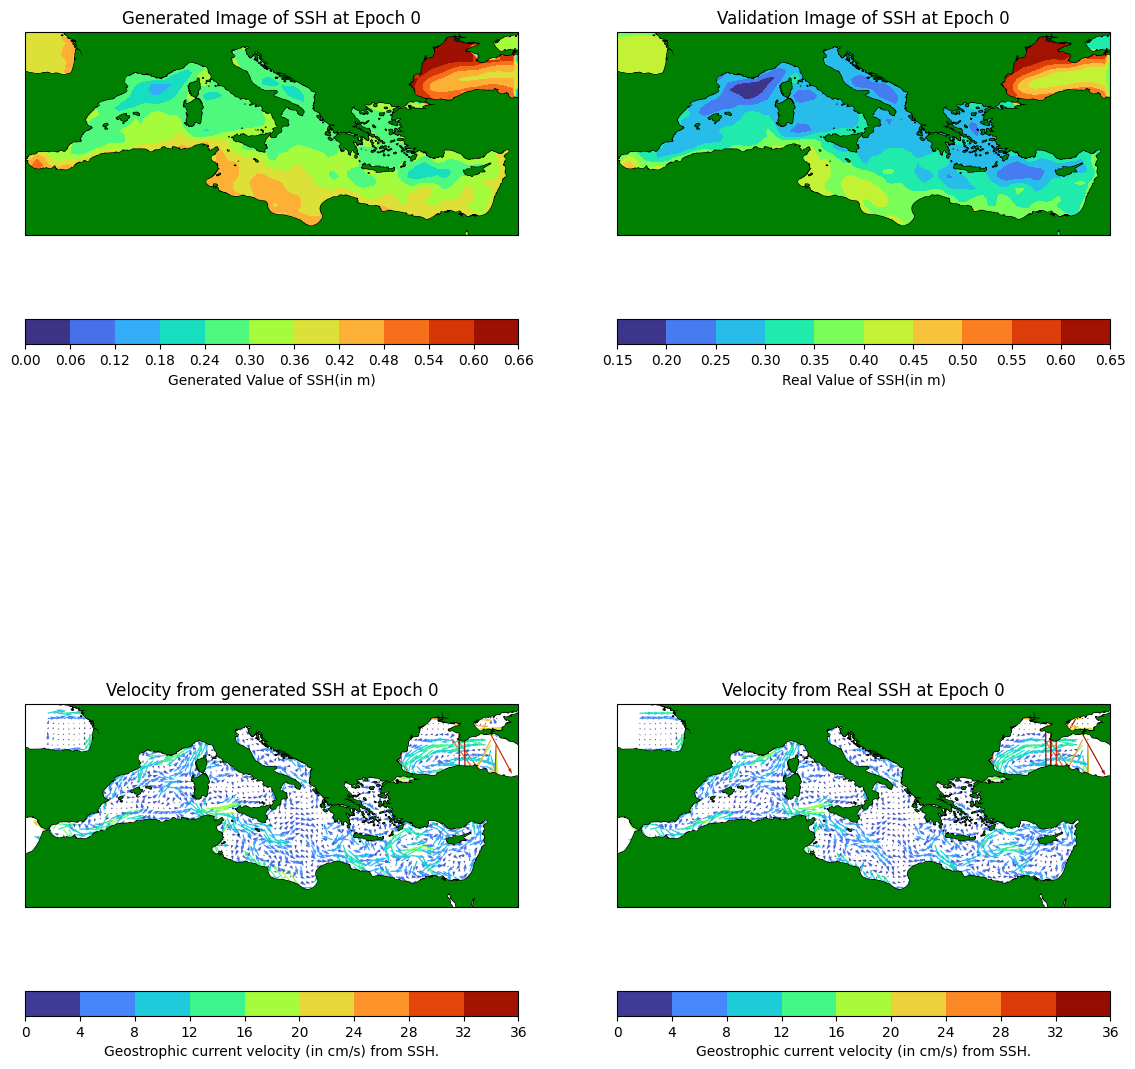

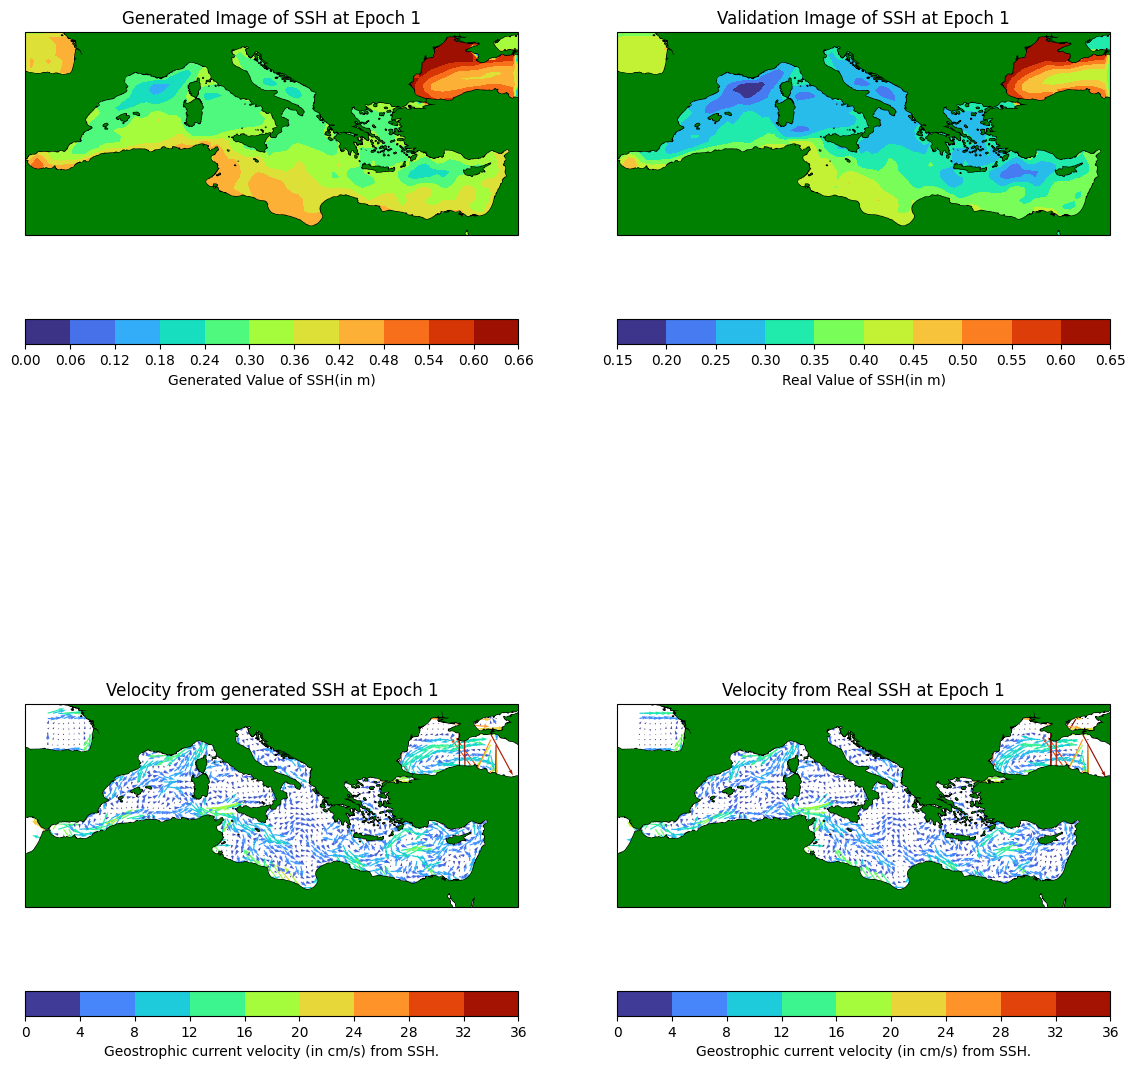

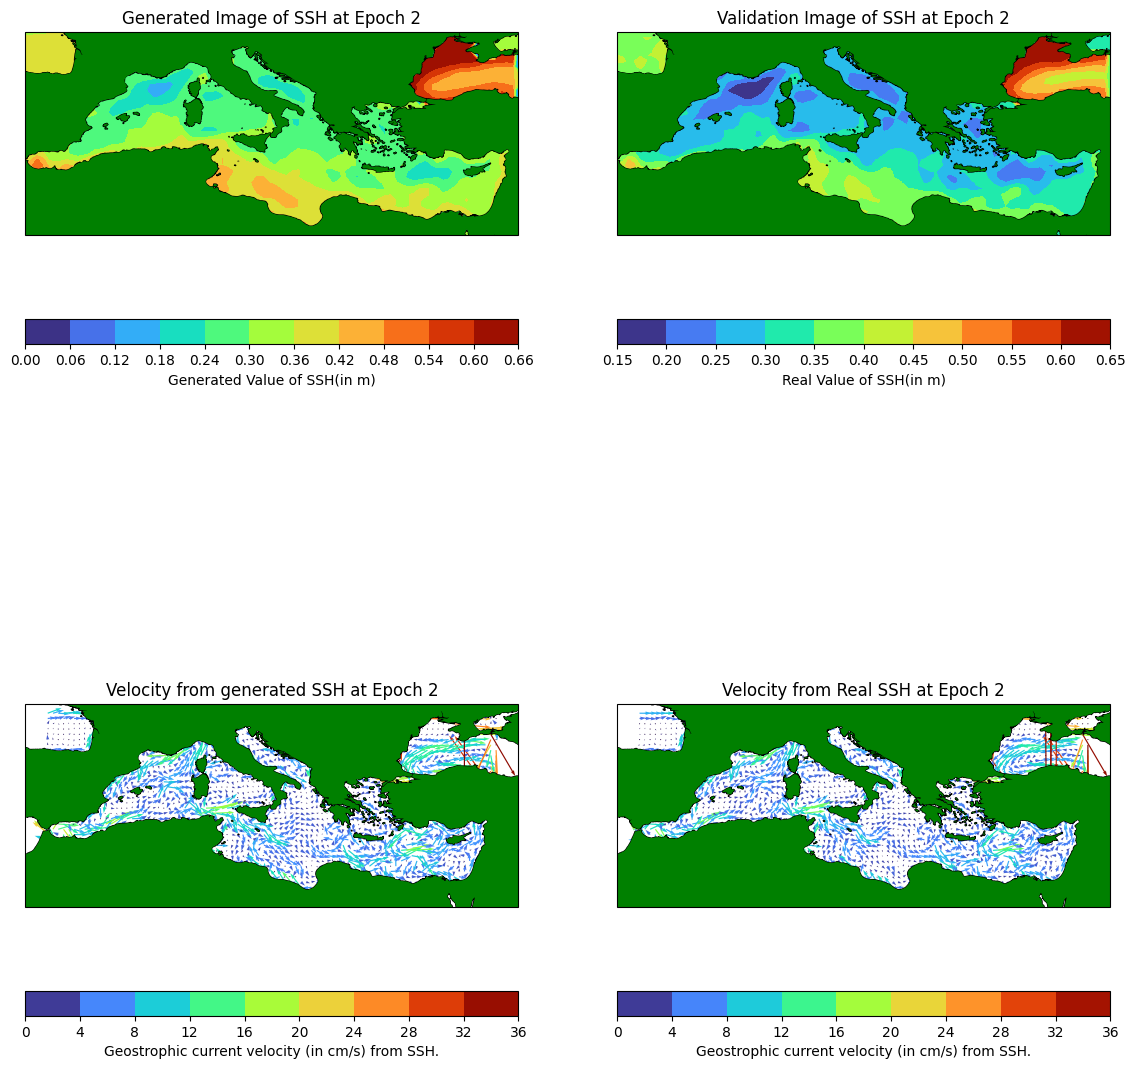

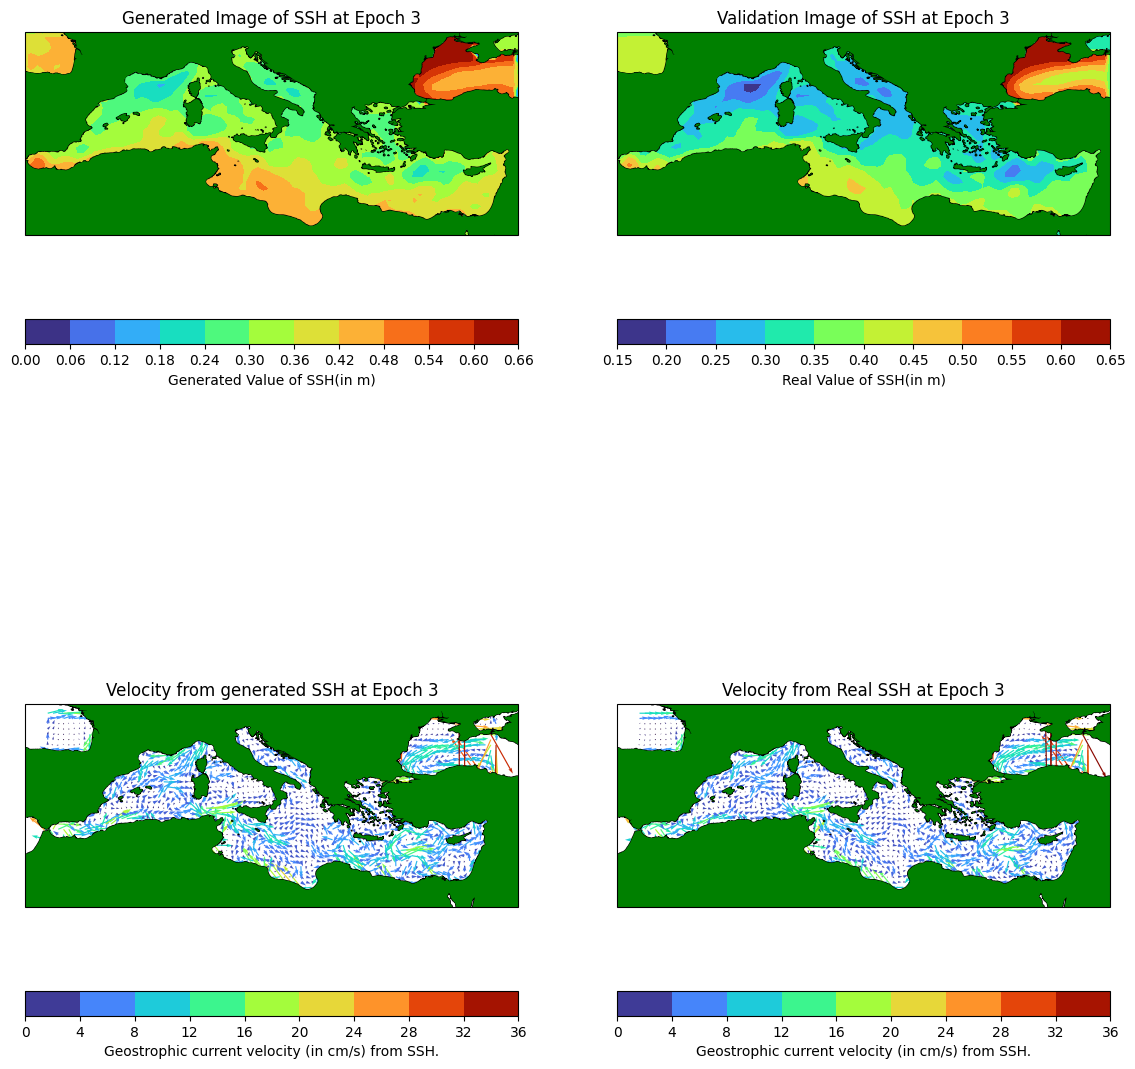

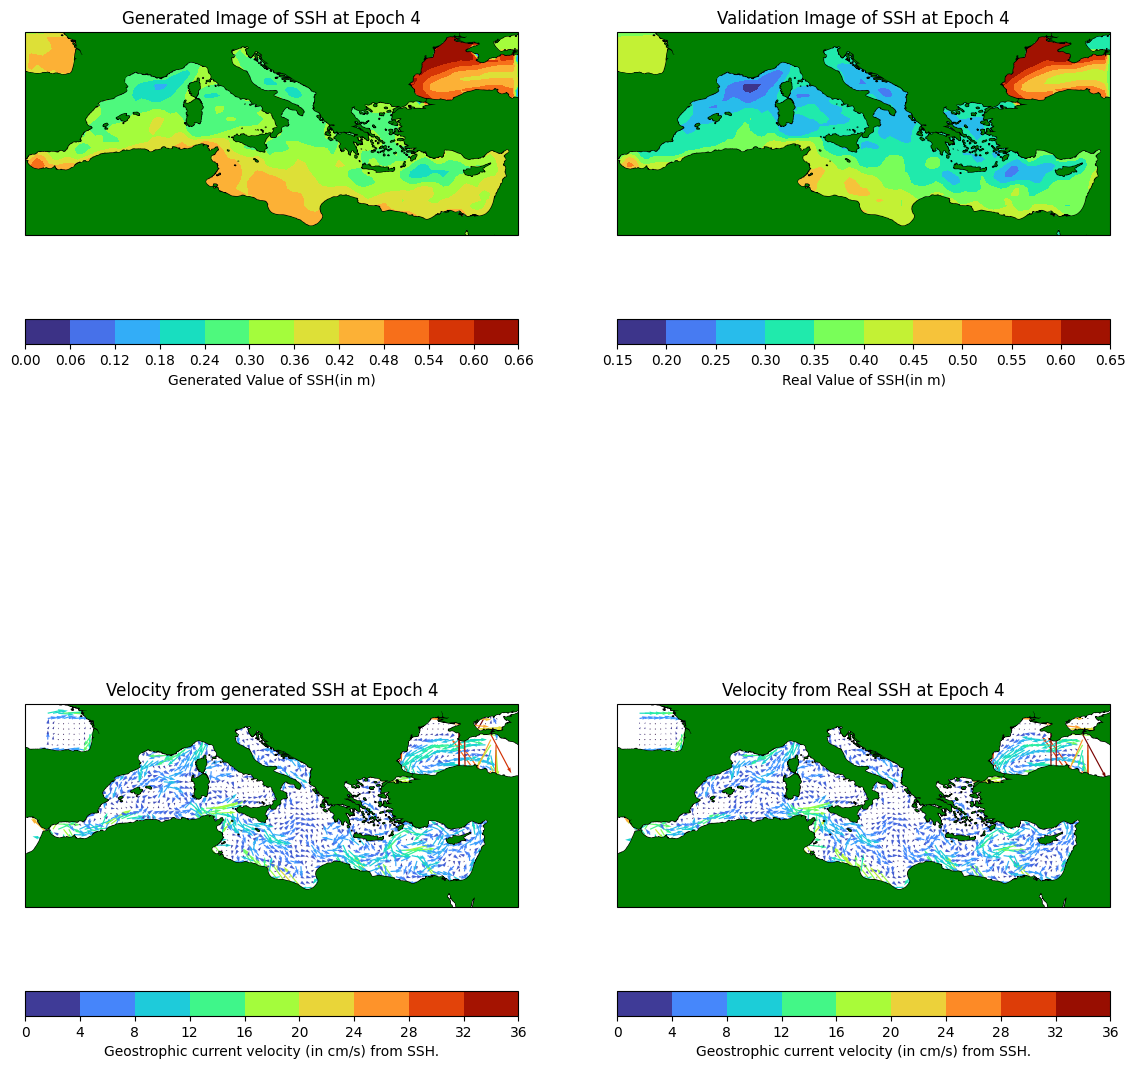

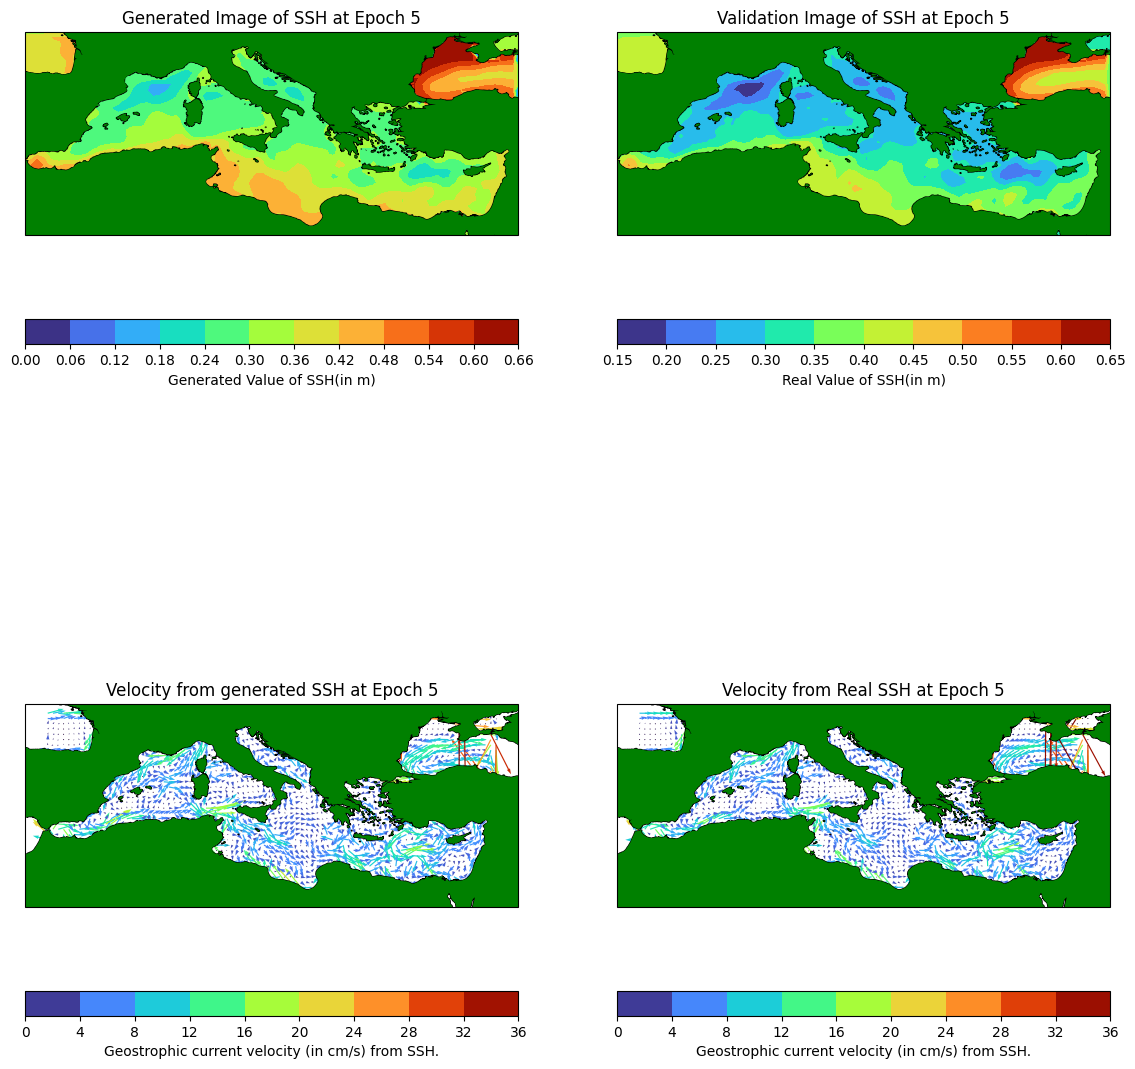

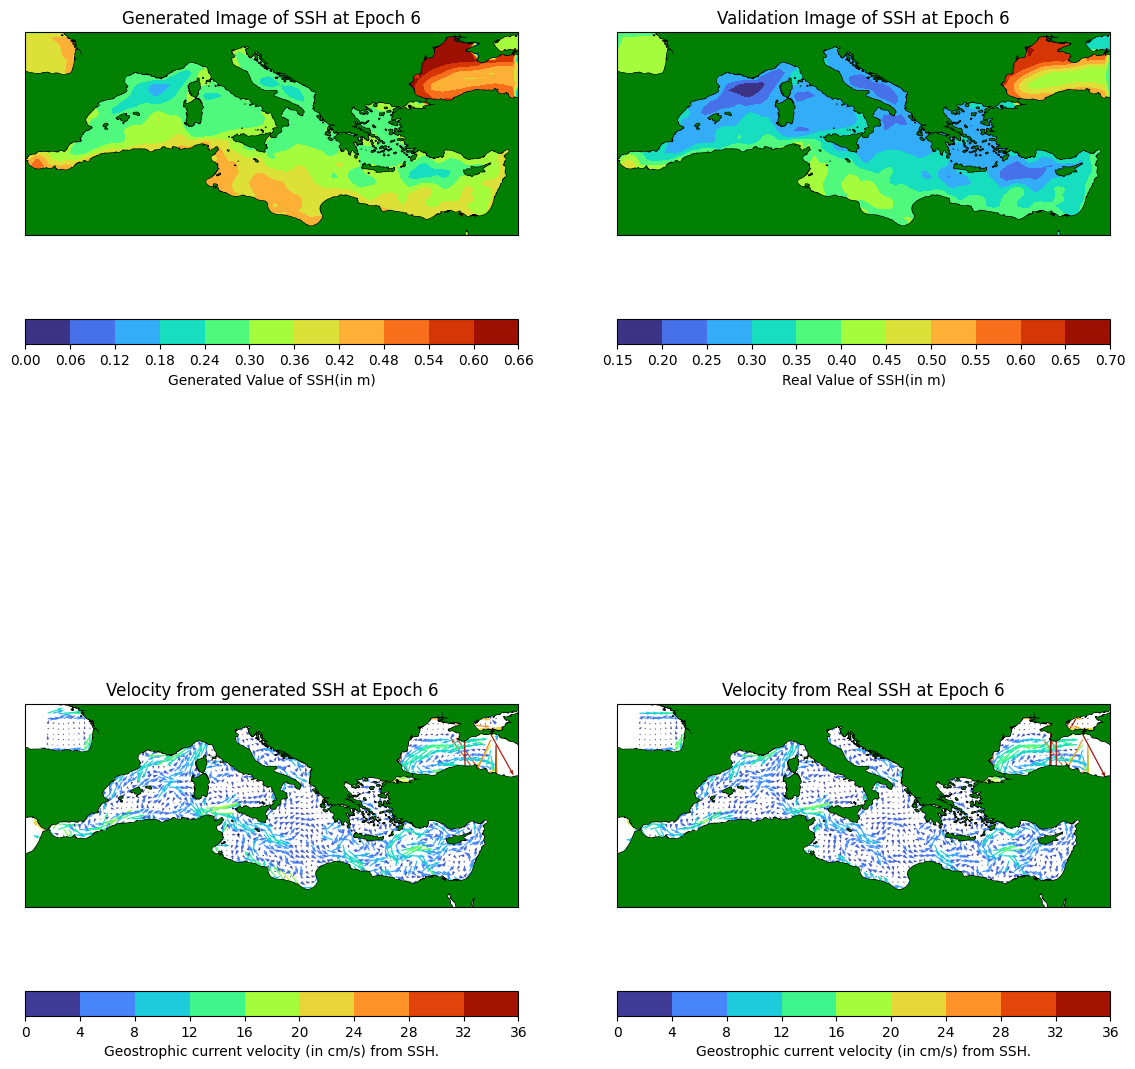

In [ ]:
generated_samples = validate_gan(generator, validation_loader, input_dim, device, num_samples)

In [ ]:
def generate_samples(generator, num_samples, input_dim, device,validation_set):
  All_generated_data=[]
  generator.eval()
  with torch.no_grad():
        # Generate random noise

        # Generate fake data

    for i,batch in enumerate(validation_set):

      # print('The shape of the batch is: ',batch[0].shape)
      real_data = batch[0][:, :, :, :86].to(device).float()  # Ensure the data is of type float32
      batch_time=batch[0][:, 0, 0, 86:].to(device)
      noise = torch.randn(batch_time.shape[0], input_dim, device=device)
      print('the noise and time data shape is: ',noise.shape,batch_time.shape)
      x=torch.cat((noise,batch_time),dim=1)
      fake_data = generator(noise,batch_time)
      # print(fake_data.shape)
      # print(real_data.shape)
      All_generated_data.append((fake_data,real_data))

  return All_generated_data

In [ ]:
All_generated_data=generate_samples(generator, num_samples, input_dim, device,validation_loader)

the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])
the noise and time data shape is:  torch.Size([32, 200]) torch.Size([32, 14])


In [ ]:
Testing_data=[]
Generated_data=[]
for i in range(len(All_generated_data)):
    xi,xj = All_generated_data[i]
    Generated_data.append(xi)
    Testing_data.append(xj)

In [ ]:
final_testing=torch.cat(Testing_data,dim=0)
final_generated=torch.cat(Generated_data,dim=0)

In [ ]:
final_testing.shape

torch.Size([224, 1, 36, 86])

In [ ]:

# from cuml.ensemble import RandomForestRegressor as cuRF
# from cuml.metrics import mean_squared_error
# from cuml.model_selection import train_test_split
# import numpy as np
# import torch

# # Generate synthetic data for training
# num_samples = 224
# num_features = 10  # Example number of features

# # Replace these with your actual generated and testing datasets
# final_generated = torch.rand(num_samples, num_features)  # Example tensor
# final_testing = torch.rand(num_samples, num_features)    # Example tensor

# # Flatten the images and create dummy target values
# X = final_generated.detach().cpu().numpy().reshape(num_samples, -1)
# y = final_testing.detach().cpu().numpy().reshape(num_samples, -1)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train a RandomForestRegressor on GPU
# model = cuRF()
# model.fit(X_train, y_train)

# # Evaluate the model on the test set
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Generate synthetic data for training
num_samples = 224
# synthetic_data = generate_synthetic_data(generator, num_samples, input_dim)

# Flatten the images and create dummy target values
X = final_generated.detach().cpu().numpy().reshape(num_samples, -1)
y = final_testing.detach().cpu().numpy().reshape(num_samples, -1)  # Dummy target values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple machine learning model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0016018703572834


In [ ]:
# Compute R² score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,mean_absolute_error
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Compute per-pixel (per-feature) MSE and MAE
mse_per_pixel = mean_squared_error(y_test, y_pred, multioutput='raw_values')
mae_per_pixel = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

# Aggregate metrics
mean_mse_per_pixel = np.mean(mse_per_pixel)
mean_mae_per_pixel = np.mean(mae_per_pixel)

print(f"Mean MSE per pixel: {mean_mse_per_pixel}")
print(f"Mean MAE per pixel: {mean_mae_per_pixel}")

# Optionally, analyze or visualize the per-pixel errors
for i in range(len(mse_per_pixel)):
    print(f"Pixel {i}: MSE={mse_per_pixel[i]}, MAE={mae_per_pixel[i]}")

R² Score: 0.6748760985469968
Mean MSE per pixel: 0.0016018703572834
Mean MAE per pixel: 0.019162834213842045
Pixel 0: MSE=0.0, MAE=0.0
Pixel 1: MSE=0.0, MAE=0.0
Pixel 2: MSE=0.0, MAE=0.0
Pixel 3: MSE=0.0, MAE=0.0
Pixel 4: MSE=0.0, MAE=0.0
Pixel 5: MSE=0.0, MAE=0.0
Pixel 6: MSE=0.0, MAE=0.0
Pixel 7: MSE=0.0, MAE=0.0
Pixel 8: MSE=0.0, MAE=0.0
Pixel 9: MSE=0.0, MAE=0.0
Pixel 10: MSE=0.0, MAE=0.0
Pixel 11: MSE=0.0, MAE=0.0
Pixel 12: MSE=0.0, MAE=0.0
Pixel 13: MSE=0.0, MAE=0.0
Pixel 14: MSE=0.0, MAE=0.0
Pixel 15: MSE=0.0, MAE=0.0
Pixel 16: MSE=0.0, MAE=0.0
Pixel 17: MSE=0.0, MAE=0.0
Pixel 18: MSE=0.0, MAE=0.0
Pixel 19: MSE=0.0, MAE=0.0
Pixel 20: MSE=0.0, MAE=0.0
Pixel 21: MSE=0.0, MAE=0.0
Pixel 22: MSE=0.0, MAE=0.0
Pixel 23: MSE=0.0, MAE=0.0
Pixel 24: MSE=0.0, MAE=0.0
Pixel 25: MSE=0.0, MAE=0.0
Pixel 26: MSE=0.0, MAE=0.0
Pixel 27: MSE=0.0, MAE=0.0
Pixel 28: MSE=0.0, MAE=0.0
Pixel 29: MSE=0.0, MAE=0.0
Pixel 30: MSE=0.0, MAE=0.0
Pixel 31: MSE=0.0, MAE=0.0
Pixel 32: MSE=0.0, MAE=0.0
Pixel 33: 

In [ ]:
plt.figure(figsize=[18,8])
plt.plot(mse_per_pixel,label='MSE per pixel')
plt.xlabel('Pixels Number')
plt.ylabel('MSE')
plt.legend()
plt.savefig('/content/MyDrive/MyDrive/filtered_mutant/ssh-gan/ssh-gan/Validation_GAN_COMPLEX/validation_loss_mse_COMPLEX.png',dpi=300)
plt.show()
# plt.plot(mae_per_pixel,label='MAE per pixel')

NameError: name 'plt' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Generate synthetic data for training
num_samples = 100
synthetic_data = generate_synthetic_data(generator, num_samples, input_dim)

# Flatten the images and create dummy target values
X = synthetic_data.detach().cpu().numpy().reshape(num_samples, -1)
y = np.random.randn(num_samples)  # Dummy target values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple machine learning model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 1.0639304695984984
